# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [4]:
!pip install comet_ml --quiet

requests 2.18.4 has requirement urllib3<1.23,>=1.21.1, but you'll have urllib3 1.26.14 which is incompatible.
botocore 1.12.7 has requirement urllib3<1.24,>=1.20, but you'll have urllib3 1.26.14 which is incompatible.


In [5]:
!pip install fasttext --quiet

In [6]:
!pip install contractions --quiet

In [7]:
!pip install pyLDAvis==3.0.0 --quiet

In [8]:
# import libraries
import ast
import glob
import re
import os
import pandas as pd
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import numpy as np
import nltk
import string
import fasttext
import contractions
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.util import ngrams



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('universal_tagset')


%matplotlib inline
from sqlalchemy import create_engine
from comet_ml import Artifact, Experiment
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/opt/conda/lib/python3.6/site-packages/requests/__init__.py:84: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib import pyopenssl


We will be using Comet Artifacts for dataset versionning. This will provide us with a lineage graph that shows all the steps of the ETL pipeline, taking into accounts all the different versions of the data.

In [10]:
COMET_API_KEY = "TkfogaXqILmxF0ShTe3LkgJFN"
COMET_PROJECT_NAME = "disaster_response_pipeline"
COMET_WORKSPACE = "benjtlv"
COMET_ARTIFACT = "disaster-response-data"

In [13]:
# Create a Comet Artifact
def comet_artifact(aliases):
    return Artifact(
        name=COMET_ARTIFACT,
        artifact_type="dataset",
        aliases=aliases,
        metadata={
            "task": "classification"
        }
    )

In [14]:
artifact = comet_artifact(['raw'])

In the following steps, we just load the data from the different sources. We now create a Comet Experiment, whose sole purpose will be to act as an anchor point for our data extraction step

In [15]:
def create_experiment():
    return Experiment(api_key=COMET_API_KEY, project_name=COMET_PROJECT_NAME, workspace=COMET_WORKSPACE)

In [8]:
experiment = create_experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/workspace' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/benjtlv/disaster-response-pipeline/c1db0292ee1c4e4995c5c44280c9e6f4

COMET WARNING: Error exporting current conda environment


In [9]:
# load messages dataset
messages = pd.read_csv('./messages.csv')
messages.head()

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  
0  Un front froid se retrouve sur Cuba ce matin. ...  direct  
1                 Cyclone nan fini osinon li pa fini  direct  
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct  
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct  
4  facade ouest d Haiti et le reste du pays aujou...  direct

In [11]:
# Add messages.csv to the artifact
artifact.add('./messages.csv')

In [10]:
# load categories dataset
categories = pd.read_csv('./categories.csv')
categories.head()

id                                         categories
0   2  related-1;request-0;offer-0;aid_related-0;medi...
1   7  related-1;request-0;offer-0;aid_related-1;medi...
2   8  related-1;request-0;offer-0;aid_related-0;medi...
3   9  related-1;request-1;offer-0;aid_related-1;medi...
4  12  related-1;request-0;offer-0;aid_related-0;medi...

In [13]:
artifact.add('./categories.csv')

In [14]:
experiment.add_tag('extract')

In [15]:
experiment.log_artifact(artifact)

COMET INFO: Artifact 'disaster-response-data' version 1.0.0 created
COMET INFO: Scheduling the upload of 2 assets for a size of 16.13 MB, this can take some time
COMET INFO: Artifact 'benjtlv/disaster-response-data:1.0.0' has started uploading asynchronously


LoggedArtifact(artifact_name='disaster-response-data', artifact_type='dataset', workspace='benjtlv', version=Version('1.0.0'), aliases=frozenset({'raw'}), artifact_tags=frozenset(), version_tags=frozenset(), size=0, source_experiment_key='c1db0292ee1c4e4995c5c44280c9e6f4')

COMET INFO: Artifact 'benjtlv/disaster-response-data:1.0.0' has been fully uploaded successfully


In [16]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/benjtlv/disaster-response-pipeline/c1db0292ee1c4e4995c5c44280c9e6f4
COMET INFO:   Uploads:
COMET INFO:     artifact assets     : 2 (16.13 MB)
COMET INFO:     artifacts           : 1
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In this part we will take the data we extracted previously and transform it into a dataset that is ready for analysis.

We will be creating a new Comet experiment which will contains all the transform code and will output the ready-for-analysis dataset. 

In this example we will not download the data as it is already available since we are in the same notebook, but we will still call the experiment.get_artifact method to create a new element of lineage in Comet

In [48]:
experiment = create_experiment()
experiment.add_tag('transform')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/workspace' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/benjtlv/disaster-response-pipeline/620b8e46247d4e568b9d19bb3c5221ef

COMET WARNING: Error exporting current conda environment


In [49]:
experiment.get_artifact(COMET_ARTIFACT, version_or_alias='1.0.0', workspace=COMET_WORKSPACE)

# if we didn't have messages.csv & categories.csv locally, we would need to do:
# store the result of the previous line in a variable (e.g. artifact = ...)
# artifact.download('./artifacts')
# messages = pd.read_csv('./artifacts/messages.csv')
# categories = pd.read_csv('./artifacts/categories.csv')

LoggedArtifact(artifact_name='disaster-response-data', artifact_type='dataset', workspace='benjtlv', version=Version('1.0.0'), aliases=frozenset({'raw'}), artifact_tags=frozenset(), version_tags=frozenset(), size=16918568, source_experiment_key='c1db0292ee1c4e4995c5c44280c9e6f4')

In [12]:
# merge datasets
df = messages.merge(categories, on='id')
df.head()

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct   
1                 Cyclone nan fini osinon li pa fini  direct   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct   
4  facade ouest d Haiti et le reste du pays aujou...  direct   

                                          categories  
0  related-1;request-0;offer-0;aid_related-0;medi...  
1  related-1;request-0;offer-0;aid_related-1;medi...  
2  related-1;request-0;offer-0;aid_related-0;medi...  
3  related-1;request-1;offer-0;aid_related-1;medi...  
4  related-1;request-0;offer-0;aid_related-0;medi...

### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [13]:
# create a dataframe of the 36 individual category columns
categories = df['categories'].str.split(';', expand=True)
# categories.set_axis(category_columns, axis=1)
categories.head()

0          1        2              3               4   \
0  related-1  request-0  offer-0  aid_related-0  medical_help-0   
1  related-1  request-0  offer-0  aid_related-1  medical_help-0   
2  related-1  request-0  offer-0  aid_related-0  medical_help-0   
3  related-1  request-1  offer-0  aid_related-1  medical_help-0   
4  related-1  request-0  offer-0  aid_related-0  medical_help-0   

                   5                    6           7           8   \
0  medical_products-0  search_and_rescue-0  security-0  military-0   
1  medical_products-0  search_and_rescue-0  security-0  military-0   
2  medical_products-0  search_and_rescue-0  security-0  military-0   
3  medical_products-1  search_and_rescue-0  security-0  military-0   
4  medical_products-0  search_and_rescue-0  security-0  military-0   

              9        ...                    26                      27  \
0  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
1  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
2  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
3  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
4  child_alone-0       ...         aid_centers-0  other_infrastructure-0   

                  28        29       30      31            32      33  \
0  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
1  weather_related-1  floods-0  storm-1  fire-0  earthquake-0  cold-0   
2  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
3  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
4  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   

                34               35  
0  other_weather-0  direct_report-0  
1  other_weather-0  direct_report-0  
2  other_weather-0  direct_report-0  
3  other_weather-0  direct_report-0  
4  other_weather-0  direct_report-0  

[5 rows x 36 columns]

In [17]:
# for i in range(36):
#     print(categories.iloc[:, i].unique())

In [55]:
# select the first row of the categories dataframe
row = df['categories'][0]

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = [cat.split('-')[0] for cat in row.split(';')]
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [56]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

related    request    offer    aid_related    medical_help  \
0  related-1  request-0  offer-0  aid_related-0  medical_help-0   
1  related-1  request-0  offer-0  aid_related-1  medical_help-0   
2  related-1  request-0  offer-0  aid_related-0  medical_help-0   
3  related-1  request-1  offer-0  aid_related-1  medical_help-0   
4  related-1  request-0  offer-0  aid_related-0  medical_help-0   

     medical_products    search_and_rescue    security    military  \
0  medical_products-0  search_and_rescue-0  security-0  military-0   
1  medical_products-0  search_and_rescue-0  security-0  military-0   
2  medical_products-0  search_and_rescue-0  security-0  military-0   
3  medical_products-1  search_and_rescue-0  security-0  military-0   
4  medical_products-0  search_and_rescue-0  security-0  military-0   

     child_alone       ...           aid_centers    other_infrastructure  \
0  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
1  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
2  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
3  child_alone-0       ...         aid_centers-0  other_infrastructure-0   
4  child_alone-0       ...         aid_centers-0  other_infrastructure-0   

     weather_related    floods    storm    fire    earthquake    cold  \
0  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
1  weather_related-1  floods-0  storm-1  fire-0  earthquake-0  cold-0   
2  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
3  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   
4  weather_related-0  floods-0  storm-0  fire-0  earthquake-0  cold-0   

     other_weather    direct_report  
0  other_weather-0  direct_report-0  
1  other_weather-0  direct_report-0  
2  other_weather-0  direct_report-0  
3  other_weather-0  direct_report-0  
4  other_weather-0  direct_report-0  

[5 rows x 36 columns]

### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [57]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].str.split('-').str[1]
    
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column])
categories.head()

related  request  offer  aid_related  medical_help  medical_products  \
0        1        0      0            0             0                 0   
1        1        0      0            1             0                 0   
2        1        0      0            0             0                 0   
3        1        1      0            1             0                 1   
4        1        0      0            0             0                 0   

   search_and_rescue  security  military  child_alone      ...        \
0                  0         0         0            0      ...         
1                  0         0         0            0      ...         
2                  0         0         0            0      ...         
3                  0         0         0            0      ...         
4                  0         0         0            0      ...         

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  

[5 rows x 36 columns]

### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [58]:
# drop the original categories column from `df`
df = df.drop('categories', axis=1)

df.head()

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  
0  Un front froid se retrouve sur Cuba ce matin. ...  direct  
1                 Cyclone nan fini osinon li pa fini  direct  
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct  
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct  
4  facade ouest d Haiti et le reste du pays aujou...  direct

In [59]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)

df.head()

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products      ...        \
0        0      0            0             0                 0      ...         
1        0      0            1             0                 0      ...         
2        0      0            0             0                 0      ...         
3        1      0            1             0                 1      ...         
4        0      0            0             0                 0      ...         

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  

[5 rows x 40 columns]

Now we want our current experiment to output a new version of the artifact that we used before, but with a different tag

In [60]:
artifact = Artifact(
    name=COMET_ARTIFACT,
    artifact_type="dataset",
    aliases=["transformed"],
    metadata={
        "task": "classification"
    }
)

In [61]:
df.to_csv('disaster_transformed.csv', index=False)

In [62]:
artifact.add('disaster_transformed.csv')

In [63]:
experiment.log_artifact(artifact)
experiment.end()

COMET INFO: Artifact 'disaster-response-data' version 3.0.0 created (previous was: 2.0.0)
COMET INFO: Scheduling the upload of 1 assets for a size of 6.67 MB, this can take some time
COMET INFO: Artifact 'benjtlv/disaster-response-data:3.0.0' has started uploading asynchronously
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/benjtlv/disaster-response-pipeline/620b8e46247d4e568b9d19bb3c5221ef
COMET INFO:   Downloads:
COMET INFO:     artifacts : 1
COMET INFO:   Uploads:
COMET INFO:     artifact assets     : 1 (6.67 MB)
COMET INFO:     artifacts           : 1
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1


We can now use our transformed dataset to perform an exploratory data analysis, which will help us in understanding our data, so we can clean and even add new features to the dataset.

#### Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [67]:
# check number of duplicates
df.duplicated().sum()

0

In [68]:
# drop duplicates
df = df.drop_duplicates()

In [69]:
# check number of duplicates
df.duplicated().sum()

0

## Text pre-processing

To ease the analysis and make the algorithm learn only what's important, we will proceed to Normalize, tokenize and remove stop words

In [132]:
# in this analysis we don't care about the original message
df = df.drop('original', axis=1)

#### Capitalization removal

In [140]:
df['message'] = df['message'].str.lower()

#### Expanding contractions

In [156]:
no_contract = df['message'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df['message'] = no_contract.apply(lambda x: ' '.join(map(str, x)))

###### Punctuation removal
We want to re
move punctuation here as it will probably not play an important role in the final decision

In [168]:
df['message'] = df['message'].str.replace(r"[^a-zA-Z0-9]", " ")

##### Tokenization

In [171]:
df['message'] = df['message'].apply(word_tokenize)

##### Removing Stopwords

In [175]:
stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: [word for word in x if word not in stop_words])

##### Lemmatization with POS tags

In [178]:
df['pos_tags'] = df['message'].apply(nltk.tag.pos_tag)

In [182]:
# we need the pos tags to be converted to wordnet's format in order to use the NLTK word lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

df['wordnet_pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [184]:
# we can now apply NLTK's word lemmatizer

lemmatizer = WordNetLemmatizer()
df['message'] = df['wordnet_pos_tags'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])

We can now update the Comet Artifact with the preprocessed data

In [187]:
artifact = Artifact(
    name=COMET_ARTIFACT,
    artifact_type="dataset",
    aliases=["preprocessed"],
    metadata={
        "task": "classification"
    }
)

In [188]:
df.to_csv('disaster_preprocessed.csv', index=False)

In [189]:
artifact.add('disaster_preprocessed.csv')

In [192]:
experiment = create_experiment()
experiment.get_artifact(COMET_ARTIFACT, version_or_alias='3.0.0', workspace=COMET_WORKSPACE)
experiment.log_artifact(artifact)
experiment.add_tag('preprocess')
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/benjtlv/disaster-response-pipeline/8dd65d1466ed465bb9fe2a003c83c26a
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/workspace' nor in any parent directory. You can override where Comet is looking

## 6. EDA


Let's create a Comet experiment for the EDA as well. We will be able to log some plots as well

In [16]:
experiment = create_experiment()
experiment.add_tags(['EDA', 'Phase1'])
artifact = experiment.get_artifact(COMET_ARTIFACT, version_or_alias='preprocessed', workspace=COMET_WORKSPACE)
artifact.download('./artifacts', overwrite_strategy='PRESERVE')

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/opt/conda/lib/python3.6/site-packages/comet_ml/connection.py:223: DeprecationWarning:

Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead

/opt/conda/lib/python3.6/site-packages/comet_ml/connection.py:223: DeprecationWarning:

Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead

COMET INFO: Couldn't find a Git repository in '/home/workspace' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIREC

Artifact(name='disaster-response-data', artifact_type='dataset', version=None, aliases=set(), version_tags=set())

COMET WARNING: Error exporting current conda environment


#### Class distribution

In [9]:
df = pd.read_csv('./artifacts/disaster_preprocessed.csv')
df['message'] = df['message'].apply(ast.literal_eval)

In [99]:
category_colnames = ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 
                     'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 
                     'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 
                     'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 
                     'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 
                     'other_weather', 'direct_report']
classes_df = df[category_colnames]
classes_df.head()

related  request  offer  aid_related  medical_help  medical_products  \
0        1        0      0            0             0                 0   
1        1        0      0            1             0                 0   
2        1        0      0            0             0                 0   
3        1        1      0            1             0                 1   
4        1        0      0            0             0                 0   

   search_and_rescue  security  military  child_alone      ...        \
0                  0         0         0            0      ...         
1                  0         0         0            0      ...         
2                  0         0         0            0      ...         
3                  0         0         0            0      ...         
4                  0         0         0            0      ...         

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  

[5 rows x 36 columns]

In [76]:
def save_figure(fig, title, path='./plots', ext='png'):
    fig.savefig(os.path.join(path, title + '.' + ext))

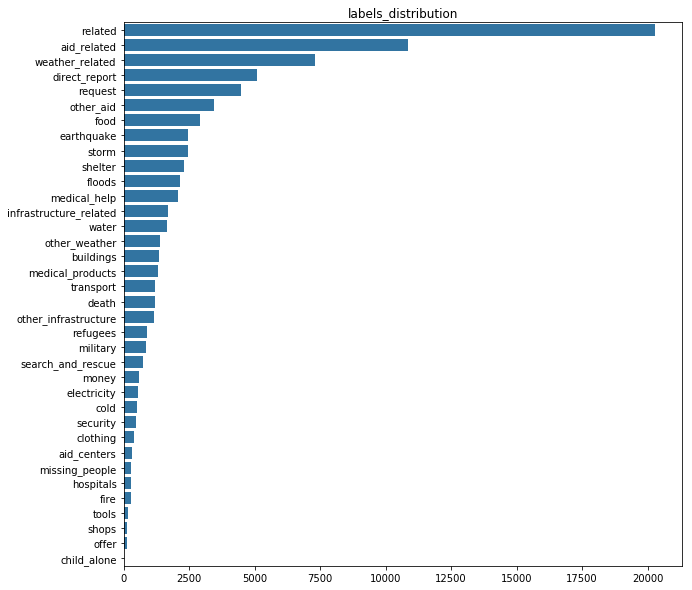

In [77]:
plt.figure(figsize=(10, 10))

title = 'labels_distribution'
base_color = sb.color_palette()[0]
class_counts = classes_df.sum().sort_values(ascending=False)
bar_plot = sb.barplot(class_counts, class_counts.index, color=base_color)
plt.title(title);
save_figure(bar_plot.get_figure(), title)

The categories seem pretty unbalanced. We can notice that we have a lot of rows labeled as related.

We can see that child alone never occurs, so we can drop it

In [100]:
df = df.drop('child_alone', axis=1)

In [101]:
del category_colnames[9]

In [102]:
print("Number of rows marked as related: ", class_counts['related'])
print("Number of total rows: ", df.shape[0])

Number of rows marked as related:  20282
Number of total rows:  26216


Let's take a brief look at the difference between messages marked as related and those not marked as such. We can use wordclouds. No need to process text right as we just want to get a general overview.

In [24]:
def most_common_words(data, limit=20):
    words = data['message']
    allwords = []
    for wordlist in words:
        allwords += wordlist
    return FreqDist(allwords).most_common(limit)

In [25]:
def get_wordcloud(data, limit=20):
    most_common = most_common_words(data, limit)
    wordcloud = WordCloud(background_color='white').generate(str(most_common))
    return wordcloud

We might want to see the distribution of the different categories across messages and see what type of messages fall under certain categories

In the plot below, we want to see how many rows have 0 label assigned, 1 label assigned, etc..

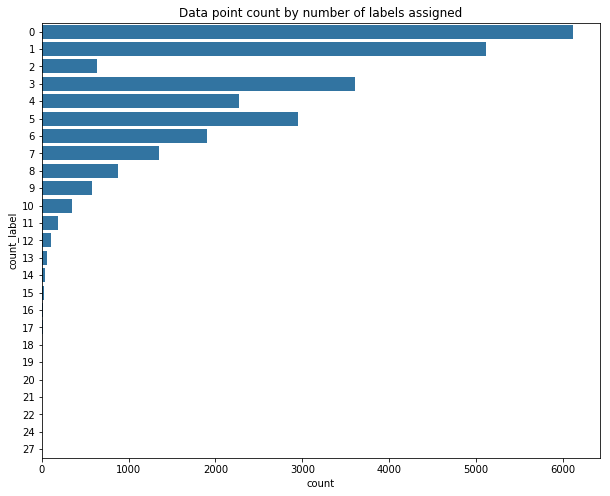

In [26]:
title = 'Multiple categories per message'
plt.figure(figsize=(10, 8))
count_labels_per_row = classes_df.sum(axis=1).to_frame(name='count_label')
count_plot = sb.countplot(data=count_labels_per_row, y='count_label', color=base_color);
plt.title(title);
save_figure(count_plot.get_figure(), title)

### Counts and Lenghts

In [179]:
# Character counts
df["char_count"] = df["message"].map(lambda x: len(x))
# Word counts
df["word_count"] = df["message"].map(lambda x: len(x.split()))
# Sentence counts
df["sent_count"] = df["message"].map(lambda x: len(sent_tokenize(x)))
# Average word length
df["avg_word_len"] = df["message"].map(lambda x: np.mean([len(w) for w in str(x).split()]))
# Average sentence length
df["avg_sent_len"] = df["message"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



We can take a look a the word clouds for each of the other categories

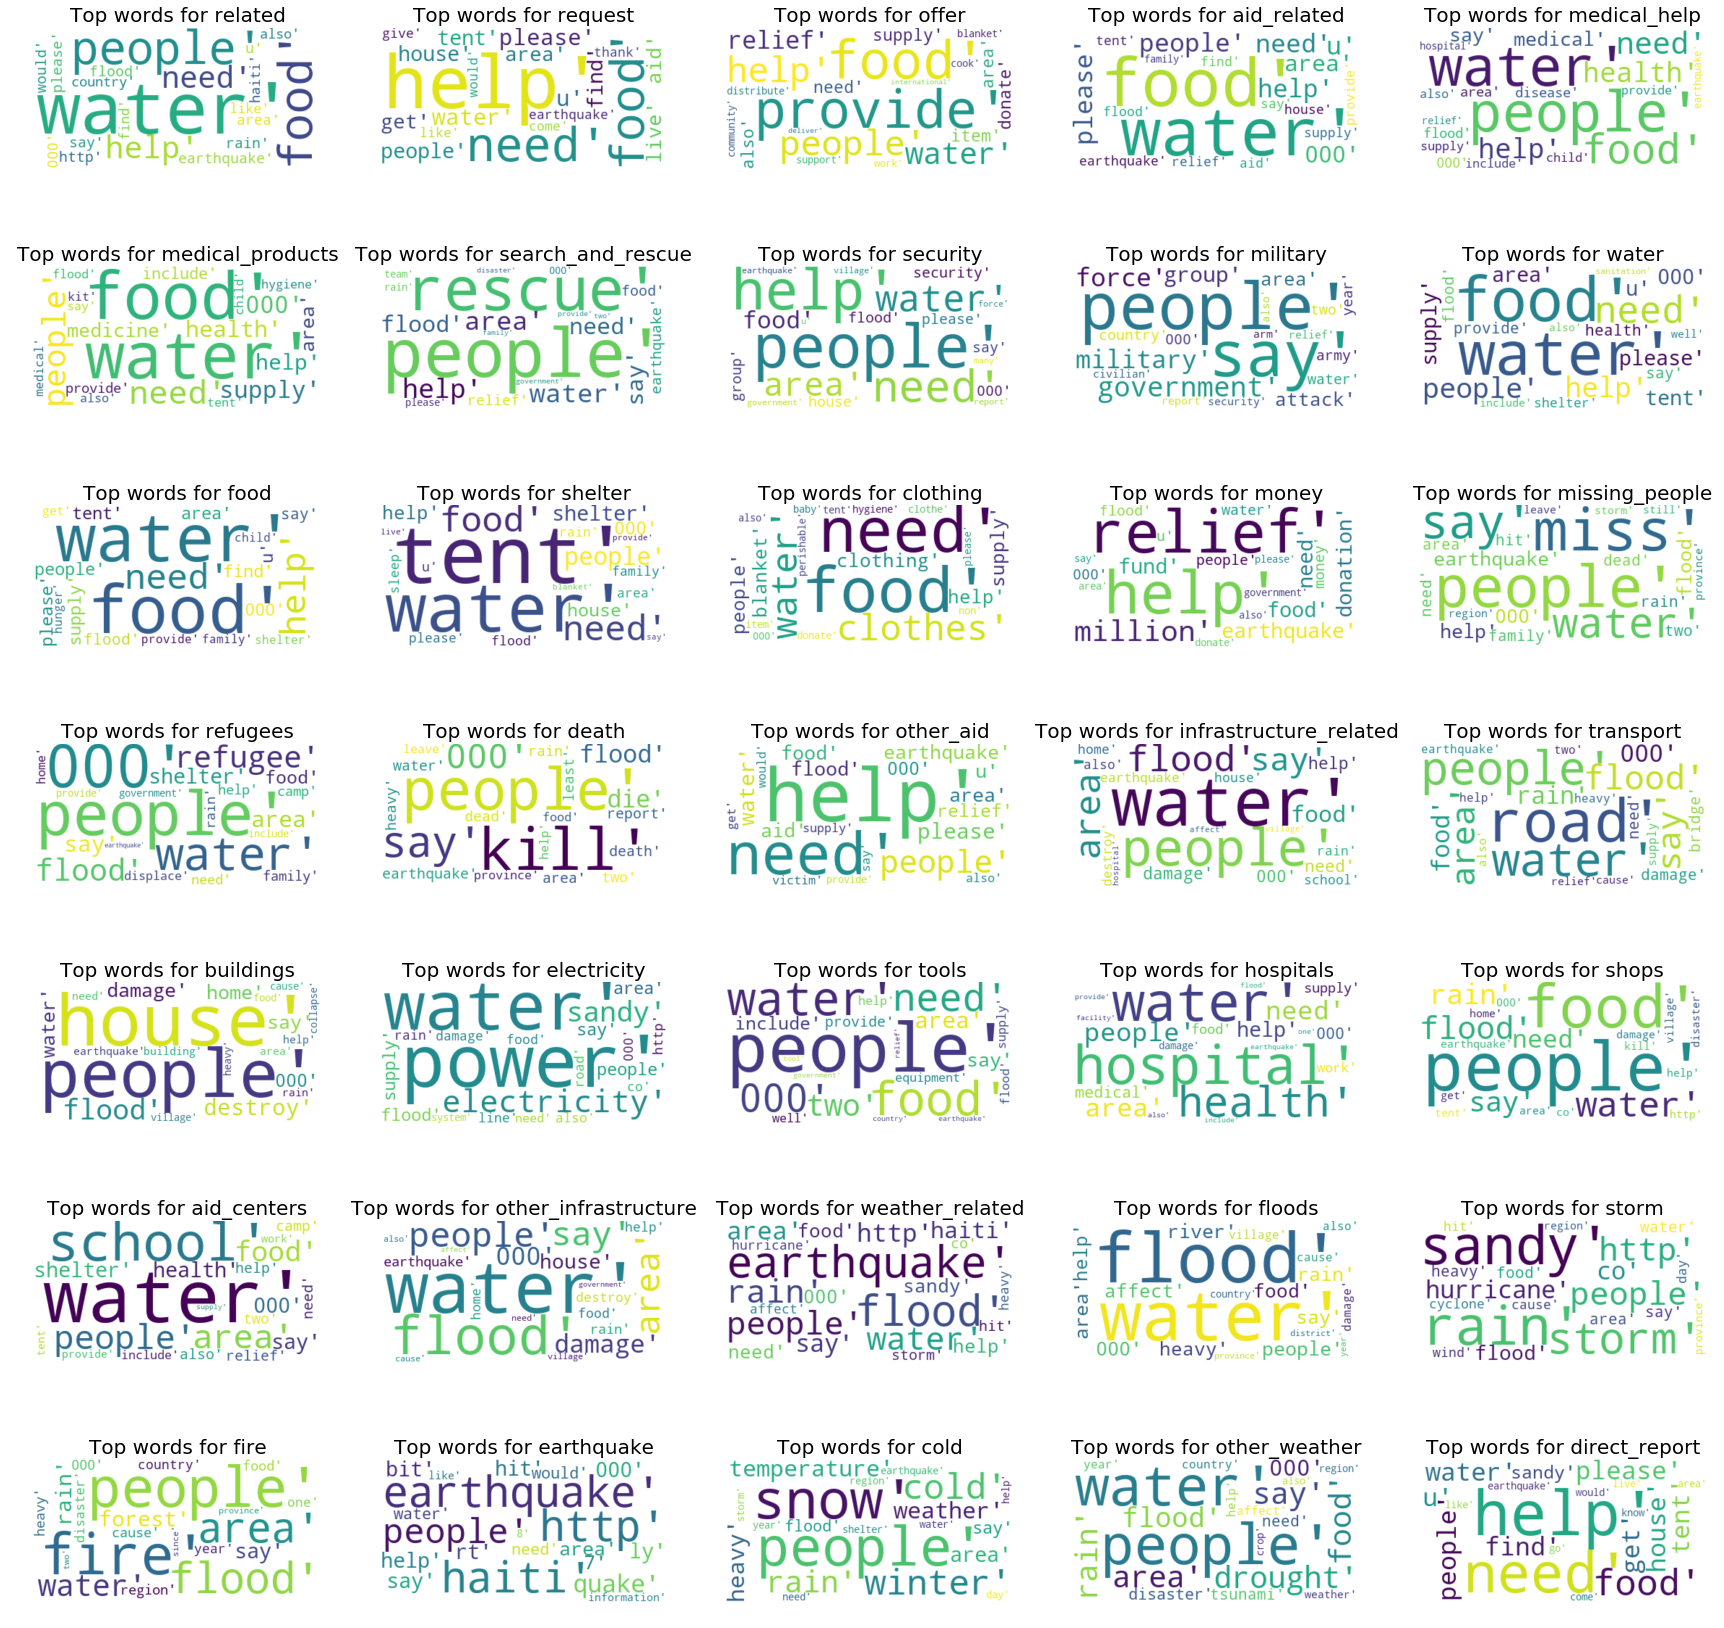

In [27]:
fig, axes = plt.subplots(7, 5, figsize=(30, 30))
axes_ravel = axes.ravel()
axes[6, 4].set_axis_off()

for i, col in enumerate(category_colnames):
    filtered_df = df[df[col] == 1]
    
    title = f"Top words for {col}"
    axes_ravel[i].set_title(title, fontsize=20)

    wordcloud = get_wordcloud(filtered_df)
    axes_ravel[i].imshow(wordcloud, interpolation="bilinear")
    axes_ravel[i].axis('off')
    
save_figure(fig, "Wordclouds per class")

We can see that when it comes to assign specific label to the message, things become a little more complex.Categories like electricity, power and electricity comes more often, which makes it easy to assign this category just by counting the word frequency. Another example is transportation with the word road. On the other hand, we can see that words like people, water, food are highly representative for categories that are not directly related to those words.

Usually, a simple frequency analysis can be as informative as wordclouds. But the fact that we have so many categories makes wordclouds very powerful, since it allows the user to get an easy understanding at what's going on with each of our categories. 
We can do the same using barplots, and confirm that it might be more exhausting to grasp what's going on in the data.

In [28]:
# from matplotlib.transforms import Bbox

# def full_extent(ax, pad=0.0):
#     """Get the full extent of an axes, including axes labels, tick labels, and
#     titles."""
#     # For text objects, we need to draw the figure first, otherwise the extents
#     # are undefined.
#     ax.figure.canvas.draw()
#     items = ax.get_xticklabels() + ax.get_yticklabels() 
# #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
#     items += [ax, ax.title]
#     bbox = Bbox.union([item.get_window_extent() for item in items])

#     return bbox.expanded(1.0 + pad, 1.0 + pad)

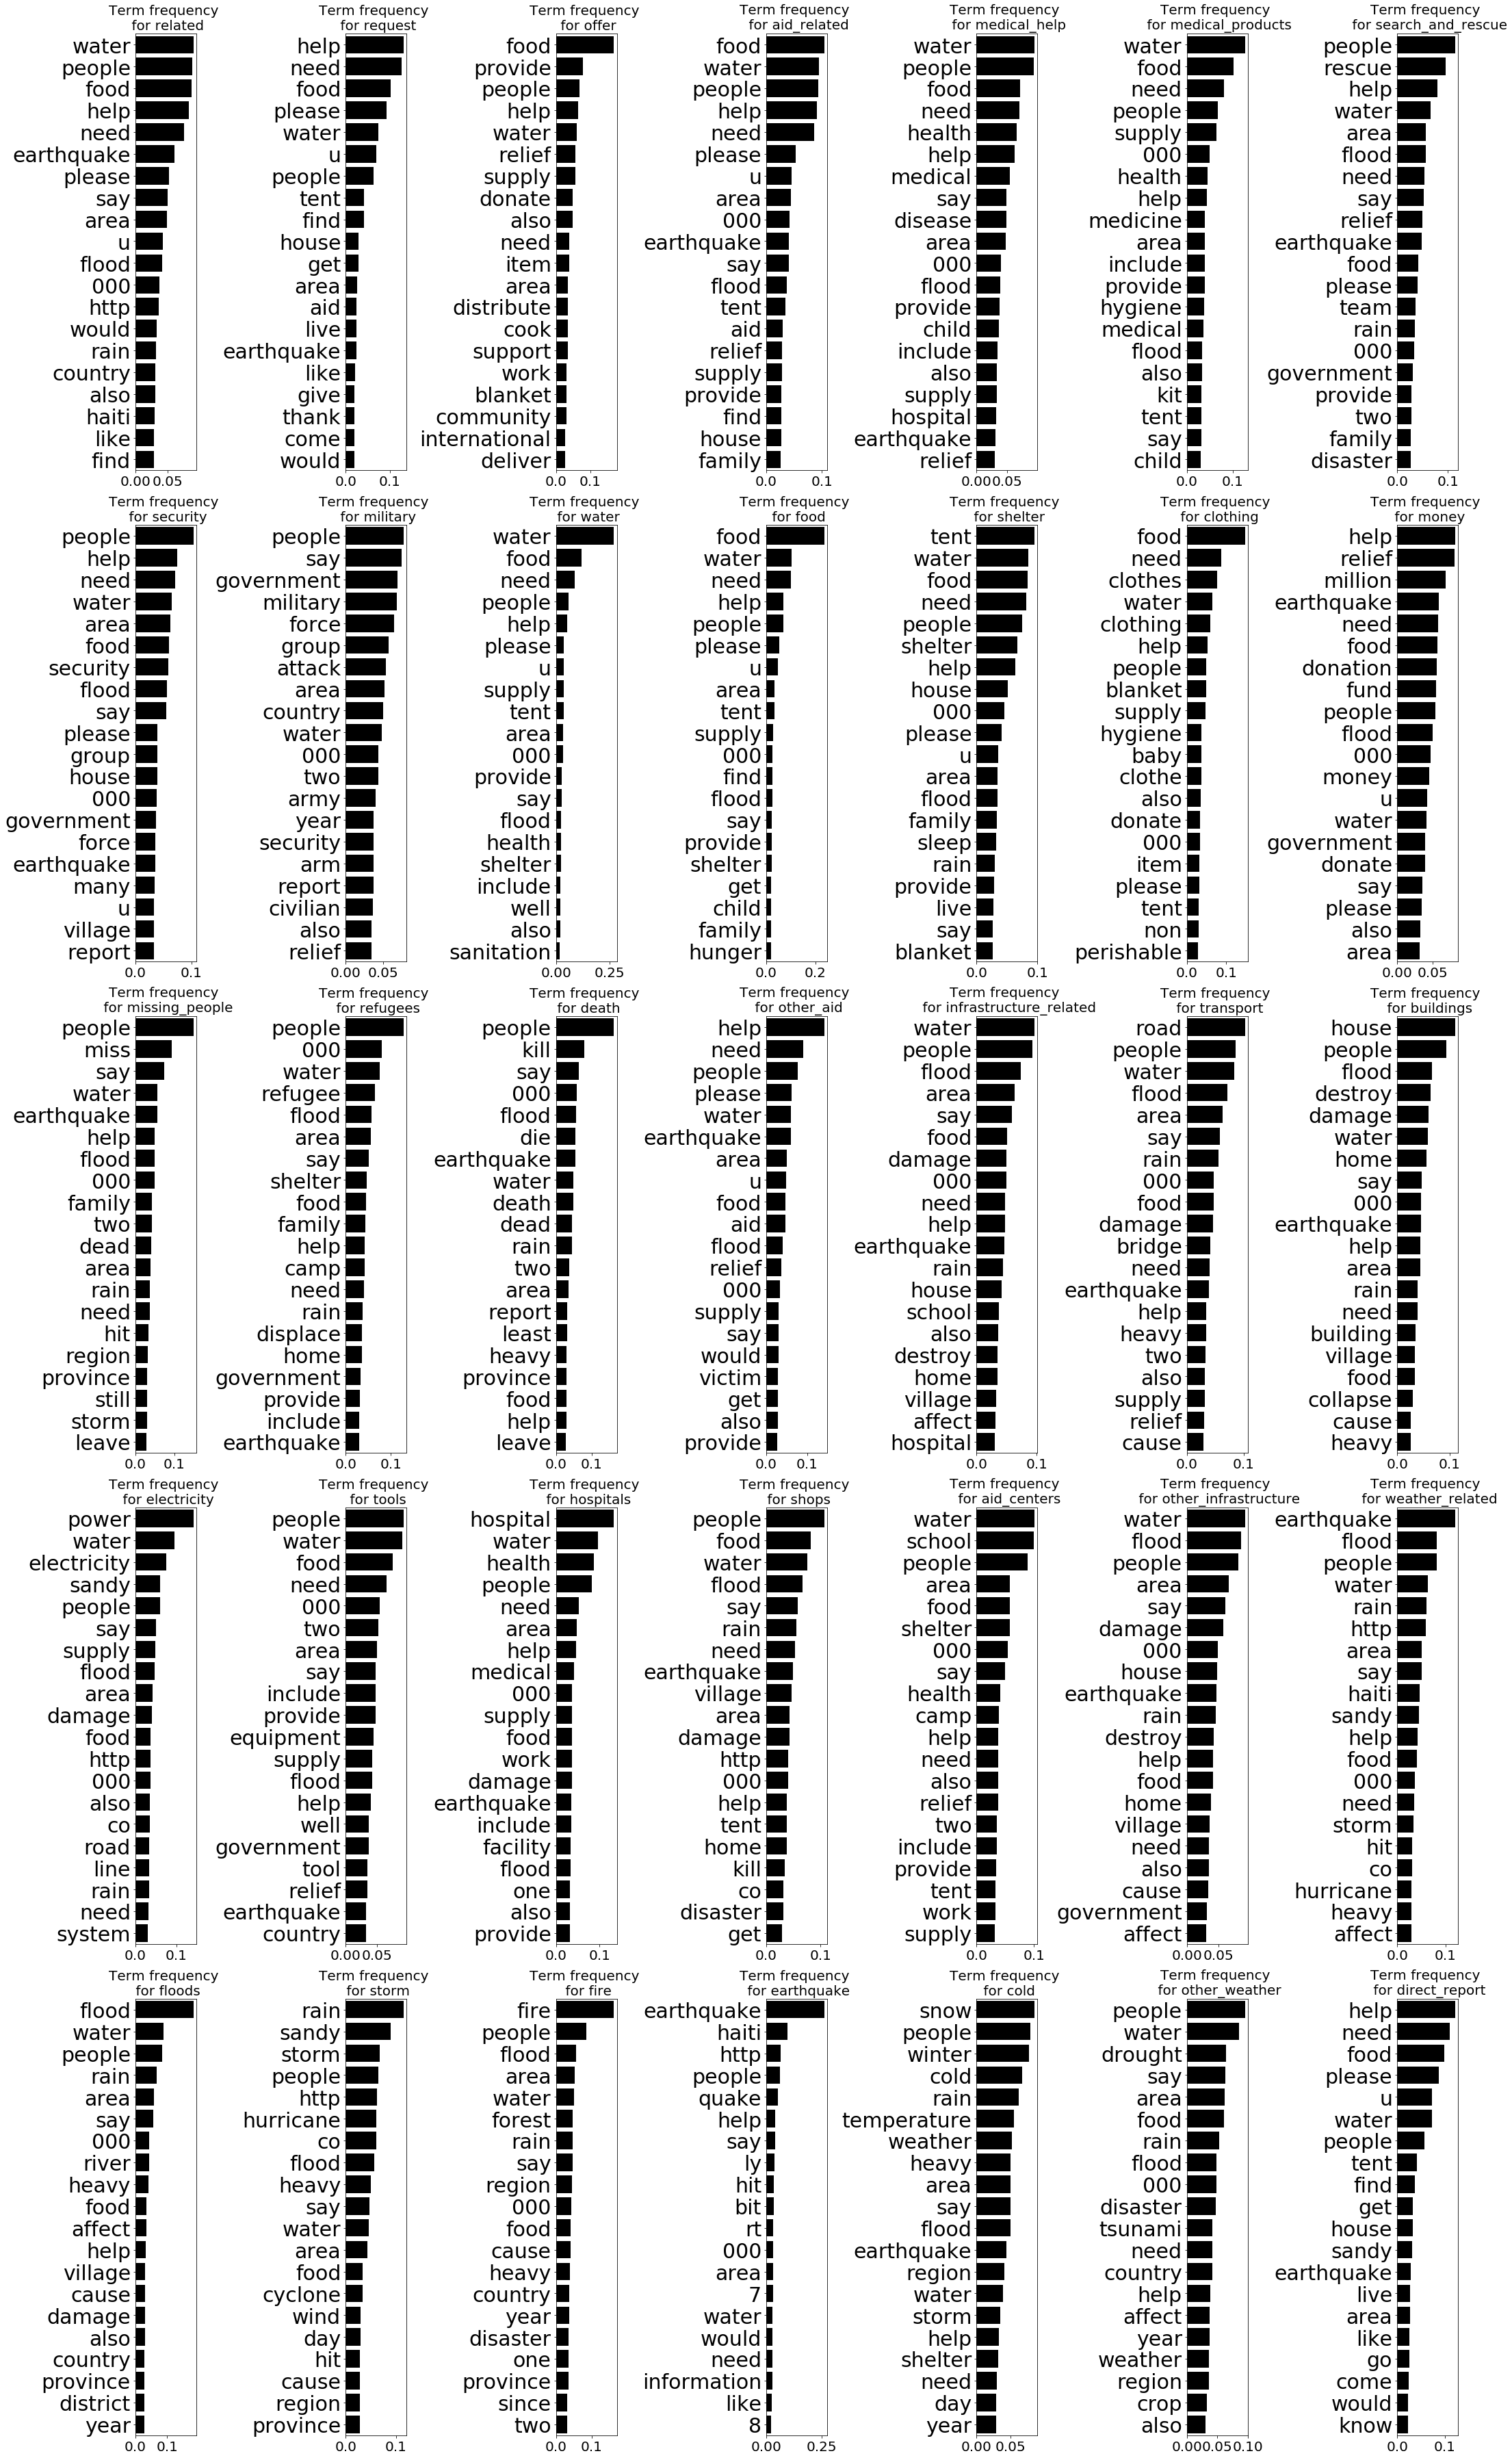

In [29]:
fig, axes = plt.subplots(5, 7, figsize=(30, 50)) 
axes_ravel = axes.ravel()

for i, col in enumerate(category_colnames):
        
    filtered_df = df[df[col] == 1]
        
    most_common = pd.DataFrame(most_common_words(filtered_df), columns=['words', 'count'])
    count_words = most_common['count'].sum()
    most_common['frequency'] = most_common['count'] / count_words
    
    title = f"Term frequency \n for {col}"
    axes_ravel[i].set_title(title, fontsize=20)
    
    sb.barplot(data=most_common, y='words', x='frequency', ax=axes_ravel[i], color='black')
    axes_ravel[i].set_xlabel("")
    axes_ravel[i].set_ylabel("")
    axes_ravel[i].tick_params(axis='x', which='major', labelsize=20)
    axes_ravel[i].tick_params(axis='y', which='major', labelsize=30)
    
# axes_ravel[-1].set_axis_off()
plt.tight_layout()
plt.show()
save_figure(fig, "Term frequencies per class")

#### Most frequent N-grams

Wordclouds might not be the best choice if we want to observe the most frequent ngrams, so we will go with frequency barplots just like above

In [103]:
df['message_list'] = df['message']
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x]))

In [82]:
def get_bigrams(data):
    text = ' '.join(data['message'].tolist())

    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(nltk.word_tokenize(text))
    return finder.ngram_fd.items()

In [83]:
def get_bigrams_frequency_df(data, limit=20):
    bigrams = get_bigrams(data)

    # pd.DataFrame.from_records(bigrams)
    bigrams_df = pd.DataFrame.from_records(list(bigrams), columns=['bigram', 'count'])
    bigrams_df['frequency'] = bigrams_df['count'] / bigrams_df['count'].sum()
    bigrams_df['bigram'] = bigrams_df['bigram'].apply(lambda x: x[0] + ' ' + x[1])
    return bigrams_df.sort_values(by='frequency', ascending=False)[['bigram', 'frequency']][:limit]

In [84]:
def plot_bigrams(df, save_plot=False, suffix=''):
    fig, axes = plt.subplots(7, 5, figsize=(30, 50)) 
    axes_ravel = axes.ravel()

    for i, col in enumerate(category_colnames):
    #     if i == 2:
    #         break
        filtered_df = df[df[col] == 1]

        bigrams_frequency_df = get_bigrams_frequency_df(filtered_df, limit=10)

        title = f"Bigram frequency \n for {col}"
        axes_ravel[i].set_title(title, fontsize=25)
        
        sb.barplot(data=bigrams_frequency_df, y='bigram', x='frequency', ax=axes_ravel[i], color='black')
        axes_ravel[i].set_xlabel("")
        axes_ravel[i].set_ylabel("")
        
        axes_ravel[i].tick_params(axis='x', which='major', labelsize=20)
        axes_ravel[i].tick_params(axis='y', which='major', labelsize=25)

    if save_plot:
        save_figure(fig, "Bigram frequencies")
    
    plt.tight_layout()
    plt.show()

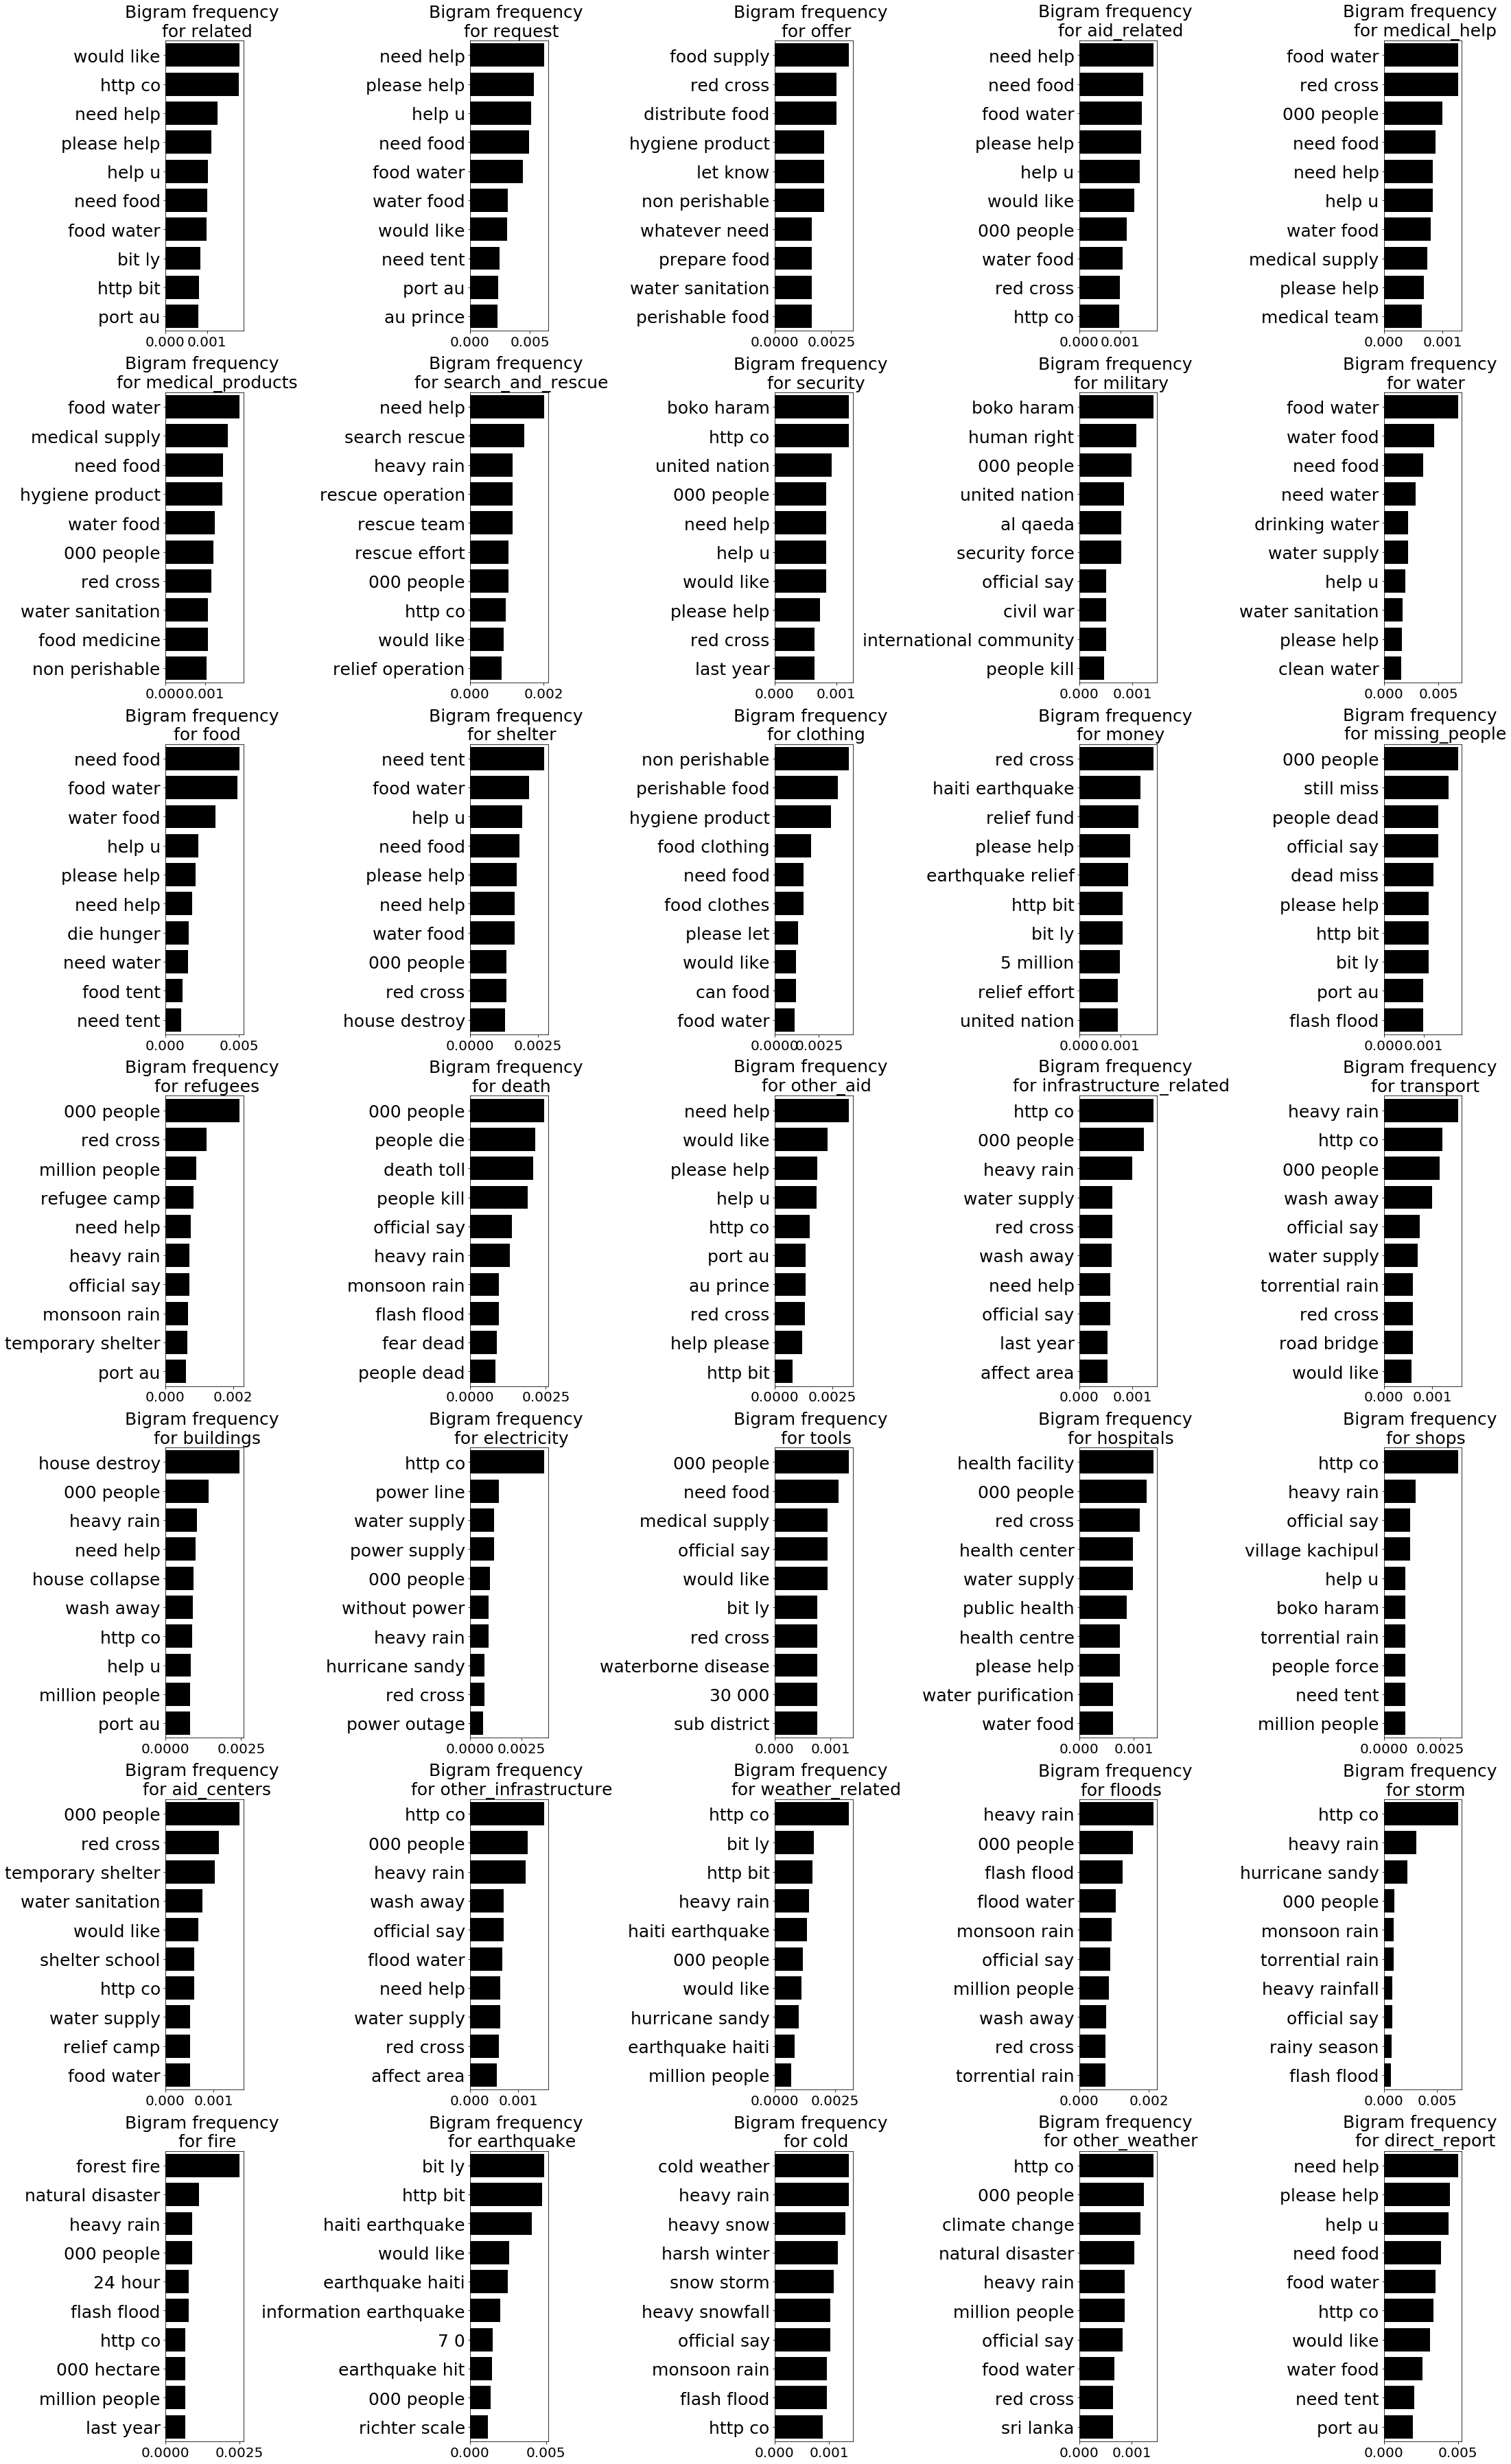

In [104]:
plot_bigrams(df)

We can see that with Bigrams, we are able to differentiate categories way better than with single words. For example, we can see that for the water category, the bigram "drinking water" comes a lot, unlike with the other categories. Also, we can see that for a lot of categories, bigrams with high frequency tend to describe the category very well: fire -> forest fire, cold -> cold weather, hospital -> health facility. However, some other categories might be hard to identify since the bigrams food water & water food have high frequency in multiple categories without being strictly related to it.
We can maybe try to remove for each categories the words composing those bigrams with high frequency.
The first we can do for sure here is getting rid of the tokens 000, http, co, bit, ly. As we can see in the above plots, they come back a lot in high frequency bigrams and can bias the algorithm.

Also, we can see that for a lot of categories, people, food, water have very high frequencies. This would probably make our model biased into thinking it has to assign those categories to data points that are really only related to food & water categories. 

What we can do now is hand pick those categories and get rid of those words inside those categories, but keep them in other relevant categories. An example of that is the bigram  "drinking water" in the water category, so we want to keep it there.

Let's remove spam words for all the messages in our dataset, then remove food, water, please, help, need, from categories that are more laser focused about one specific subject, not directly realted to those words. Because data points can have multiple labels assigned to them, this might influence categories like water, food, which we want to keep as is, let's call them the base categories. To minimize this effect we will remove those words only in data points with specific categories assigned which don't interesect with those base categories.

Let's first see the proportions of such data points

In [127]:
base_categories = ['related', 'request', 'aid_related', 'water', 'food', 'offer']
specific_categories = list(set(category_colnames) - set(base_categories))

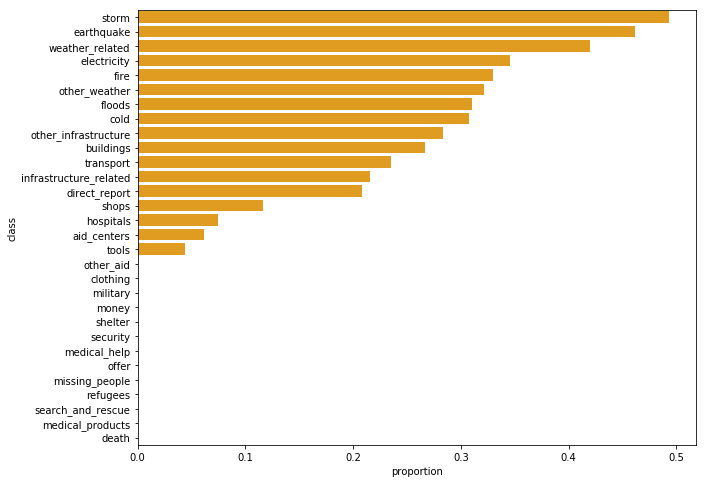

In [154]:
mask = True
for col in ['aid_related', 'water', 'food', 'offer']:
    mask &= df[col] == 0

d ={}
for col in specific_categories:
    d[col] = df[(df[col] == 1) & mask][col].sum() / df[df[col] == 1].shape[0]
s = pd.DataFrame.from_dict(d, orient='index').squeeze().sort_values(ascending=False)
dd = s.to_frame().reset_index()
dd.columns = ['class', 'proportion']

plt.figure(figsize=(10, 8))
sb.barplot(data=dd, y='class', x='proportion', color='orange')

We can see that for each specific category, more than half the datapoints have also been assigned at least one of the base categoriesl, so removing food, water, etc.. from those data points will most likely have an impact on the bigrams frequencies for the base categories.

Let's proceed with that and look at the bigrams frequencies

In [174]:
# Let's remove the irrelevant words for all categories
df['message_list'] = df['message_list'].apply(lambda x: [word for word in x if word not in ['http', 'co', '000', 'bit', 'ly', 'u', 'would', 'like', 'let', 'know', 'tell', 'port', 'au', 'prince', 'haiti', 'sri', 'lanka']])

In [175]:
for col in specific_categories:
    index = df[df[col] == 1].index
    df.loc[index, 'message_list'] = df.loc[index, 'message_list'].apply(lambda x: [word for word in x if word not in ['water', 'food', 'please', 'help', 'need']])

In [176]:
df['message'] = df['message_list'].apply(lambda x: ' '.join([word for word in x]))

Let's plot bigram frequencies again

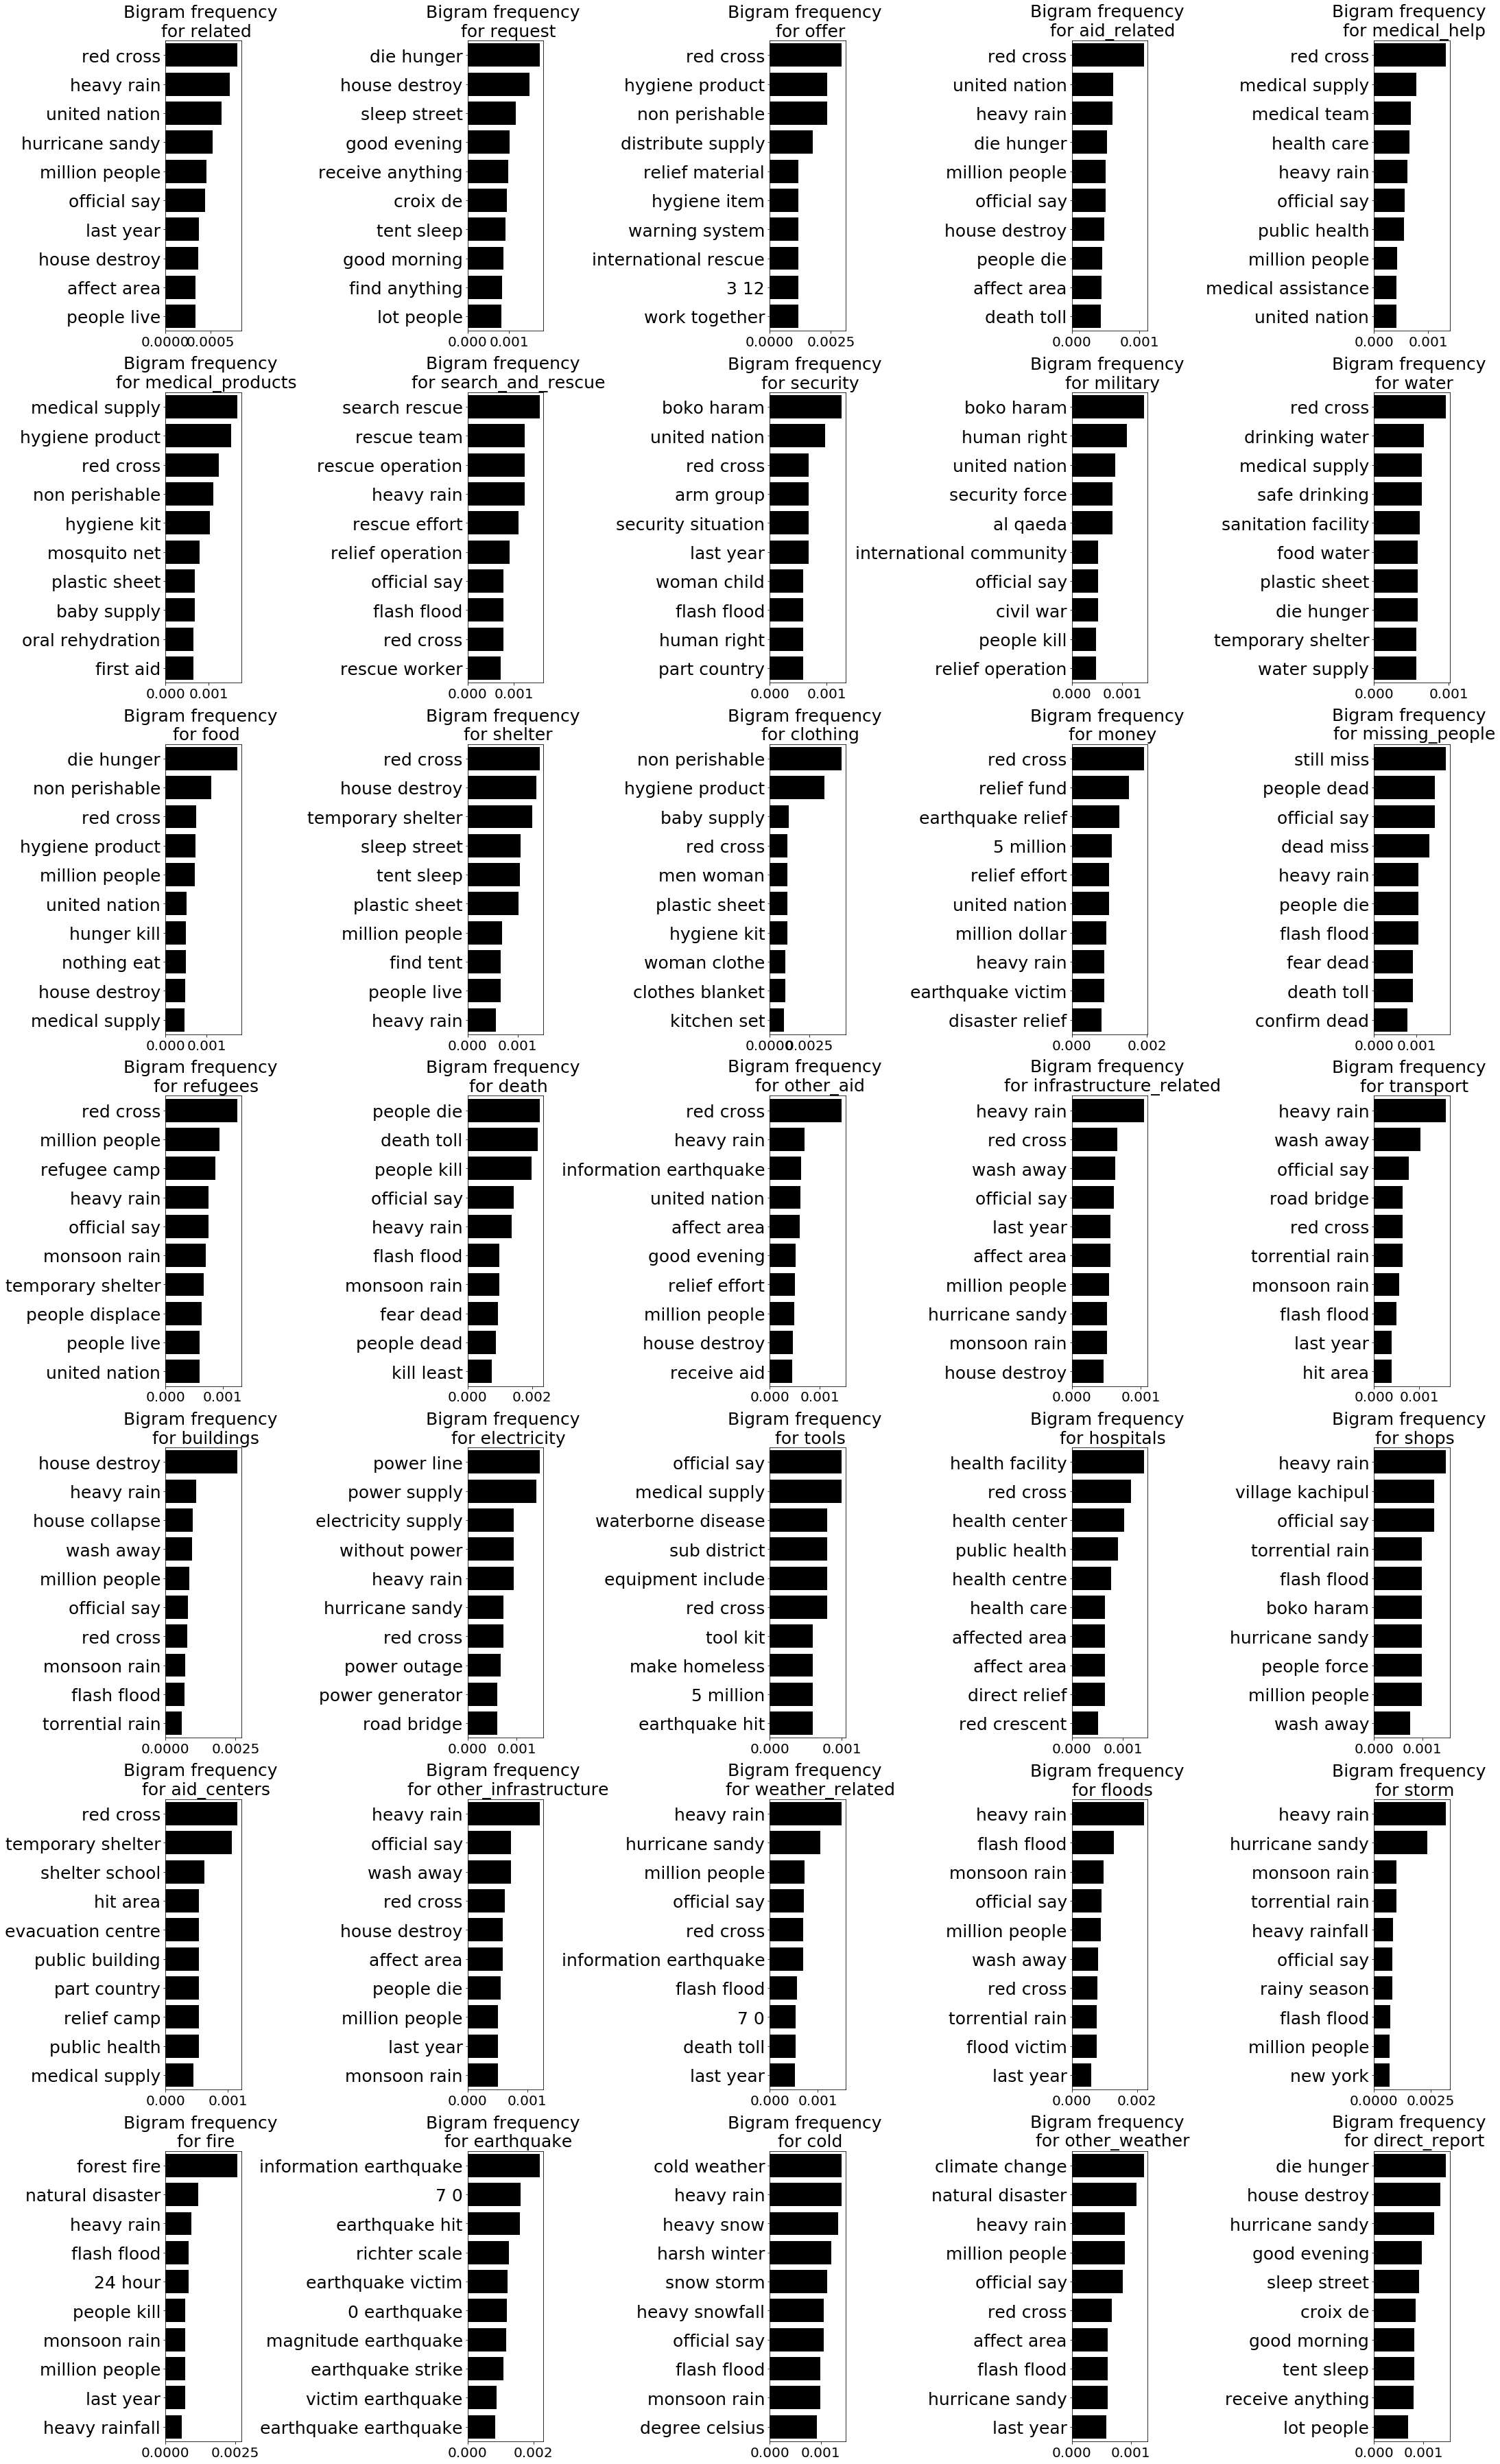

In [177]:
plot_bigrams(df, save_plot=True, suffix='clean')

We can see that the base categories weren't too affected by that. This gives us confidence in getting good results from a bigram model. The related and request categories were a bit affected, but that's a small price to pay since the genre column has a high correlation with those two categories.

In [131]:
complex_categories = ['medical_help', 'security', 'military', 'money', 'other_aid', 'infrastructure_related', 
                      'transport', 'tools', 'shops', 'other_infrastructure']

10

Additionally, let's see if there is a correlation between some of the classes and genre

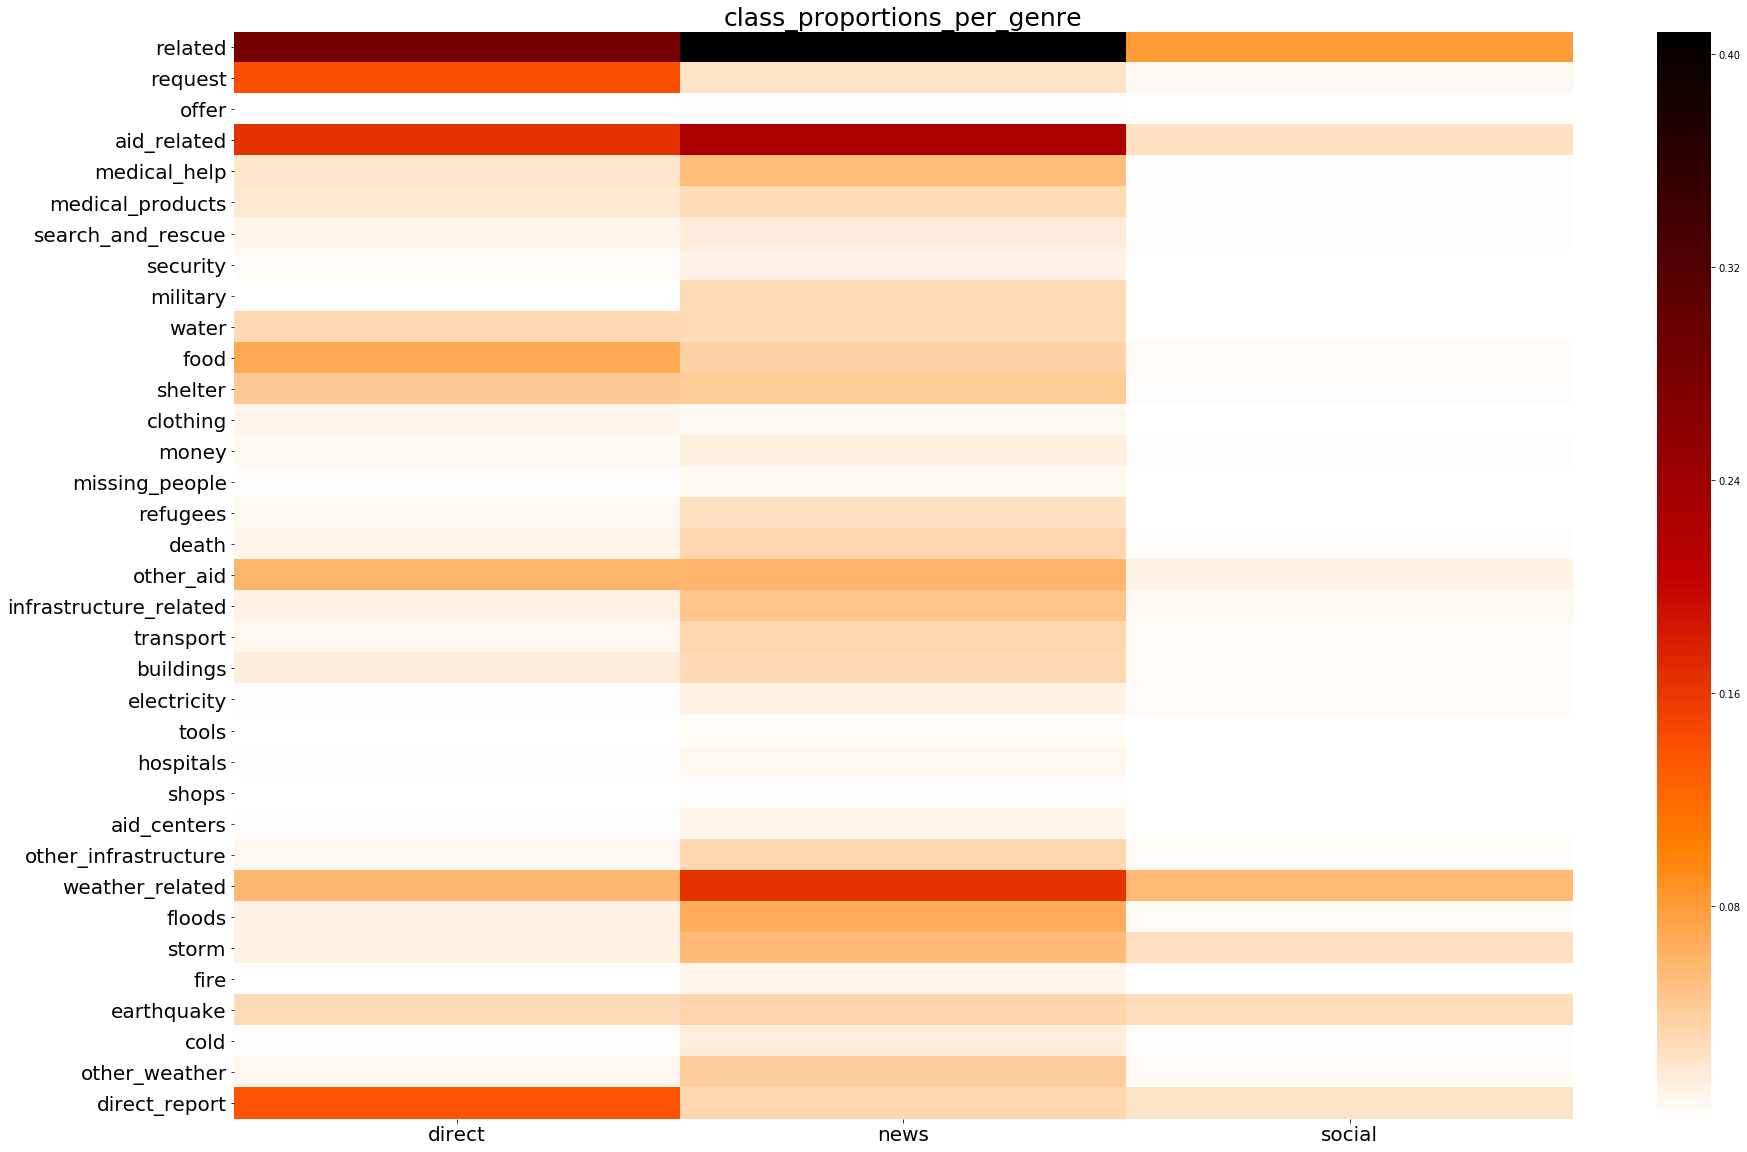

In [61]:
class_proportions_per_genre = df.groupby('genre')[category_colnames].sum() / df.shape[0]

plt.figure(figsize=(30, 20))
title="class_proportions_per_genre"
plt.title(title, fontsize=25)
heat_map = sb.heatmap(data=class_proportions_per_genre.transpose(), cmap='gist_heat_r')
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)
save_figure(heat_map.get_figure(), title)

We can proceed to building our Bigram Model

Let's log all of our figures in Comet

In [62]:
# for path in glob.glob("plots/*.png"):
#     experiment.log_image(path)

In [179]:
df = df.iloc[:, :-3] # Let's just get rid of the last 3 columns

In [180]:
artifact = comet_artifact(['preprocessed', 'ready for bigram training'])

In [181]:
df.to_csv('disaster_refined.csv', index=False)

In [182]:
artifact.add('disaster_refined.csv')

In [68]:
experiment.log_artifact(artifact)

COMET INFO: Artifact 'disaster-response-data' version 6.0.0 created (previous was: 5.0.0)
COMET INFO: Scheduling the upload of 1 assets for a size of 4.53 MB, this can take some time
COMET INFO: Artifact 'benjtlv/disaster-response-data:6.0.0' has started uploading asynchronously


LoggedArtifact(artifact_name='disaster-response-data', artifact_type='dataset', workspace='benjtlv', version=Version('6.0.0'), aliases=frozenset({'refined'}), artifact_tags=frozenset(), version_tags=frozenset(), size=0, source_experiment_key='fec17407b3f34214a855db822a38b838')

COMET INFO: Artifact 'benjtlv/disaster-response-data:6.0.0' has been fully uploaded successfully


In [69]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/benjtlv/disaster-response-pipeline/fec17407b3f34214a855db822a38b838
COMET INFO:   Downloads:
COMET INFO:     artifact assets : 1 (18.92 MB)
COMET INFO:     artifacts       : 1
COMET INFO:   Uploads:
COMET INFO:     artifact assets     : 1 (4.53 MB)
COMET INFO:     artifacts           : 1
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 6
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it 

## Advanced NLP methods

### Part-of-Speech Tagging
We used POS tagging for the lemmatization part. This time, we will use it for extracting the most common adjectives, verbs, etc.. per category. For simplicity, let's just ignore the categories easily identifiable using single terms and bigrams and let's focus on the most complex categories

In [75]:
corpus = df['message'].tolist()
tokens = word_tokenize(' '.join(corpus))

In [78]:
tags = nltk.pos_tag(tokens, tagset='universal')

In [127]:
tag_mapping = {'adjective': 'ADJ',
               'verb': 'VERB',
               'adverb': 'ADV',
               'noun': 'NOUN'}

In [120]:
def get_pos_tags_frequency_df(data, tag, tag_mapping=tag_mapping, limit=20):
    corpus = data['message'].tolist()
    tokens = word_tokenize(' '.join(corpus))
    tags = nltk.pos_tag(tokens, tagset='universal')
    pos_tags = [word for word, pos in tags if pos == tag_mapping[tag]]

    pos_df = pd.DataFrame.from_records(list(Counter(pos_tags).items()), columns=[tag, 'count'])
    pos_df['frequency'] = pos_df['count'] / pos_df['count'].sum()
    return pos_df.sort_values(by='frequency', ascending=False)[[tag, 'frequency']][:limit]

In [132]:
def plot_pos_tags(df, tag, tag_mapping=tag_mapping):
    fig, axes = plt.subplots(2, 5, figsize=(30, 20)) 
    axes_ravel = axes.ravel()

    for i, col in enumerate(complex_categories):
#         if i == 4:
#             break
        filtered_df = df[df[col] == 1]

        pos_frequency_df = get_pos_tags_frequency_df(filtered_df, tag, tag_mapping=tag_mapping, limit=10)

        title = f"{tag}s frequency \n for {col}"
        axes_ravel[i].set_title(title, fontsize=25)
        
        sb.barplot(data=pos_frequency_df, y=tag, x='frequency', ax=axes_ravel[i], color='black')
        axes_ravel[i].set_xlabel("")
        axes_ravel[i].set_ylabel("")
        
        axes_ravel[i].tick_params(axis='x', which='major', labelsize=20)
        axes_ravel[i].tick_params(axis='y', which='major', labelsize=25)

    
    plt.tight_layout()
    plt.show()

Let's take a look at the most frequent adjectives

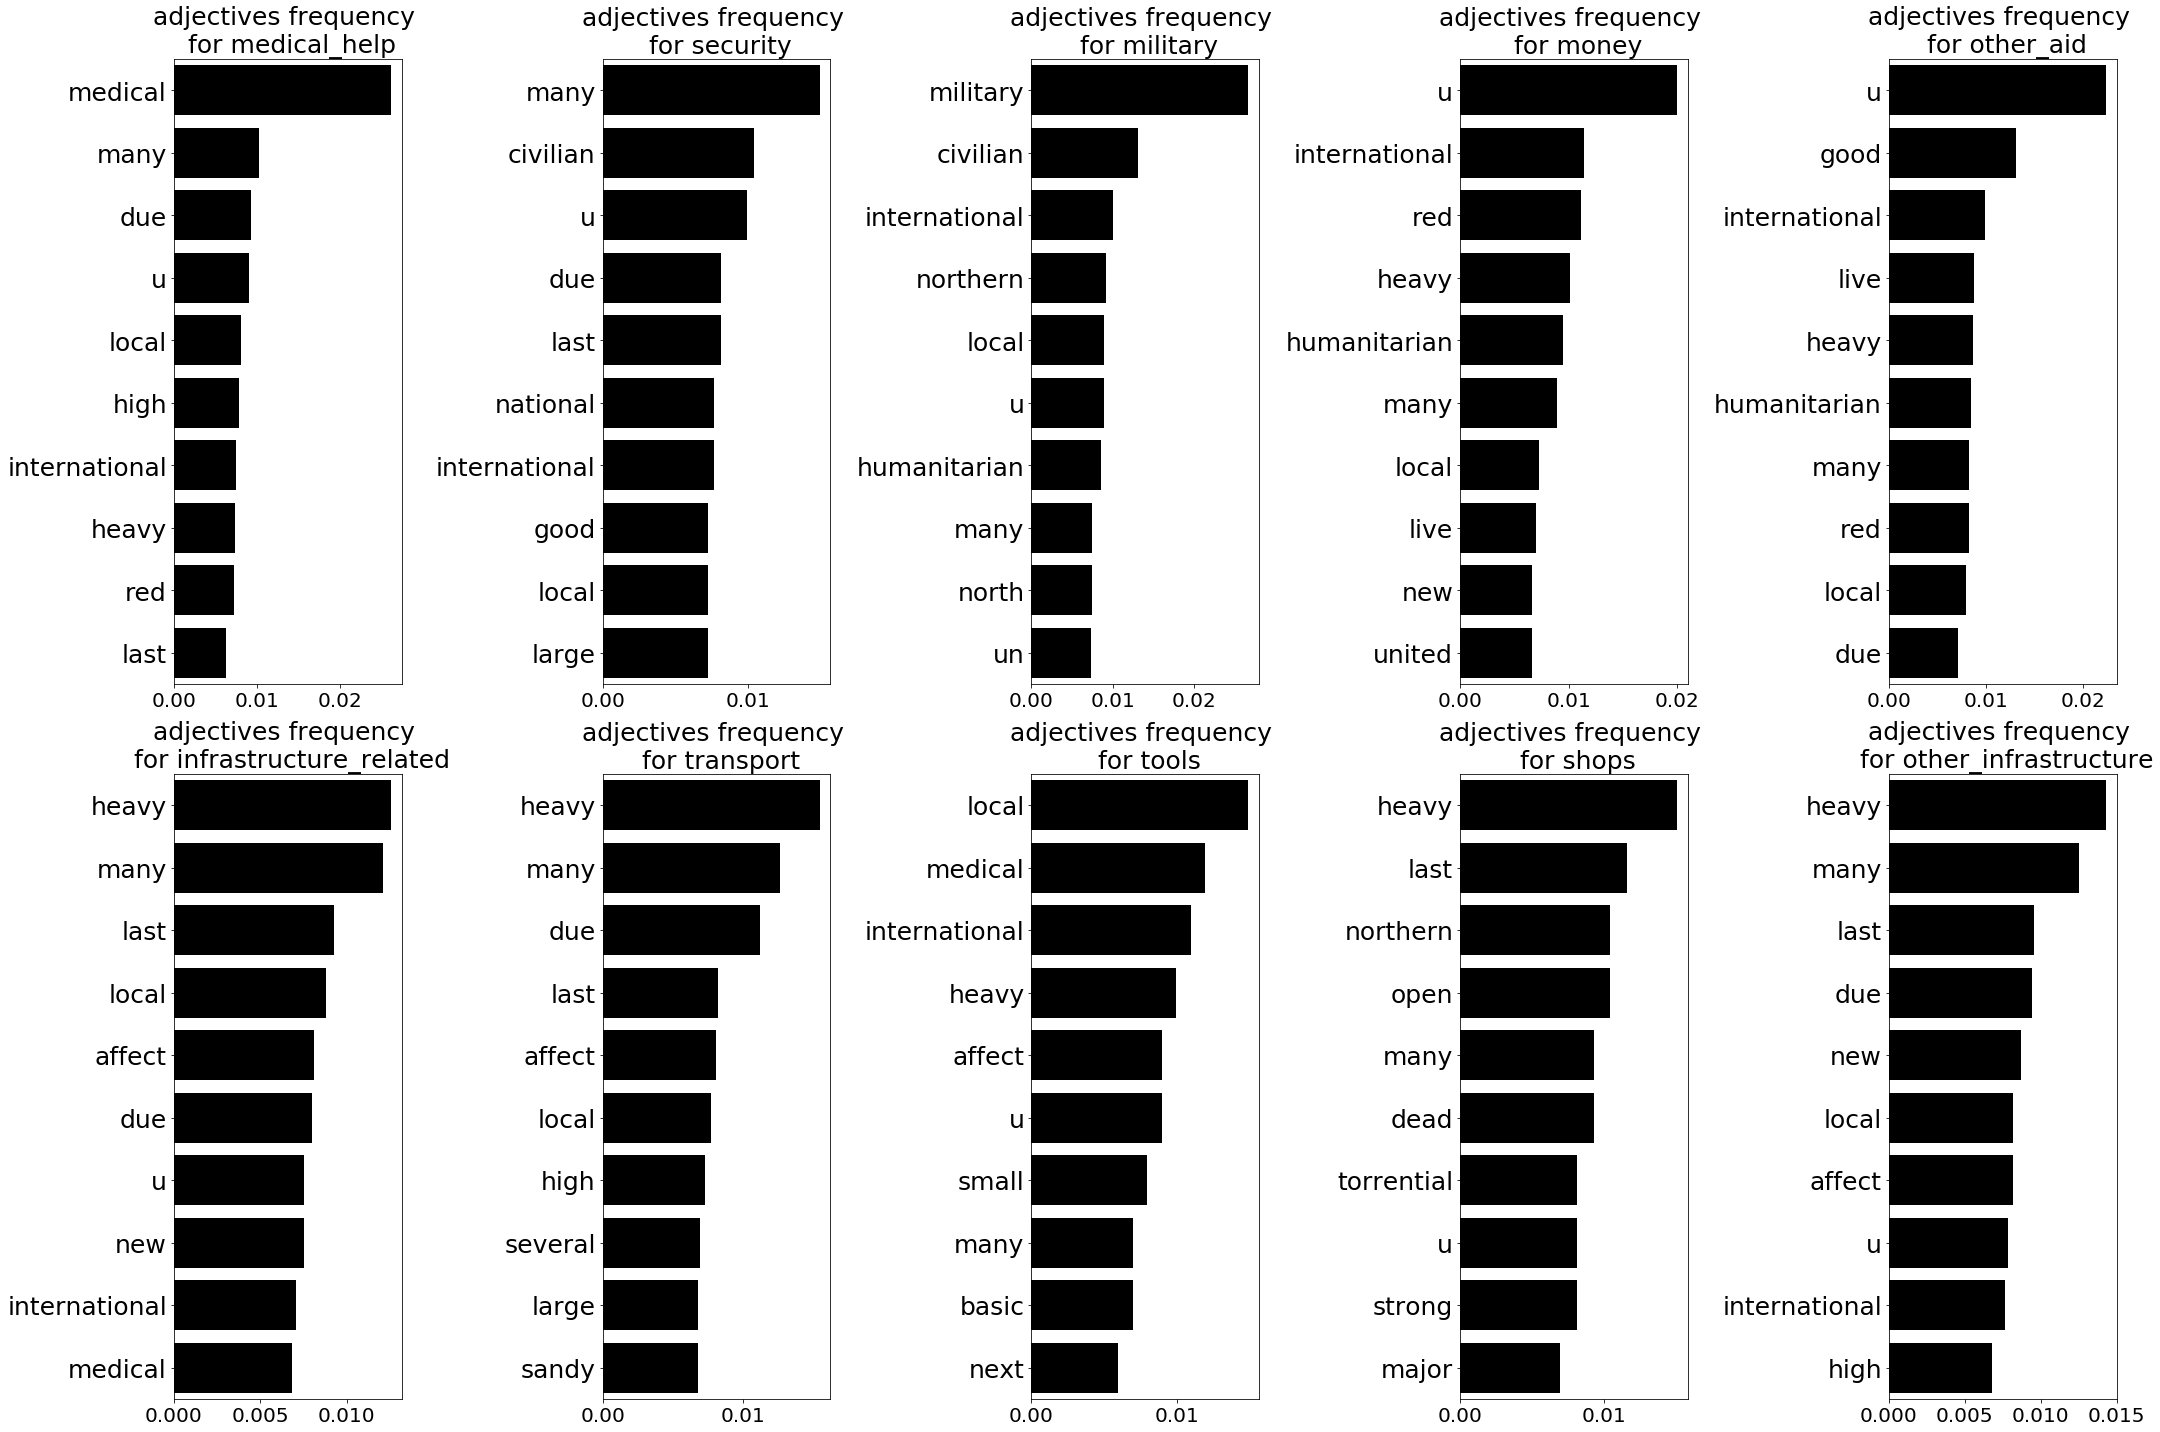

In [133]:
plot_pos_tags(df, 'adjective', tag_mapping=tag_mapping)

Seems like looking at the most frequent adjectives helped us identifying medical_help, secuirty, military. Let's take a look at verbs.

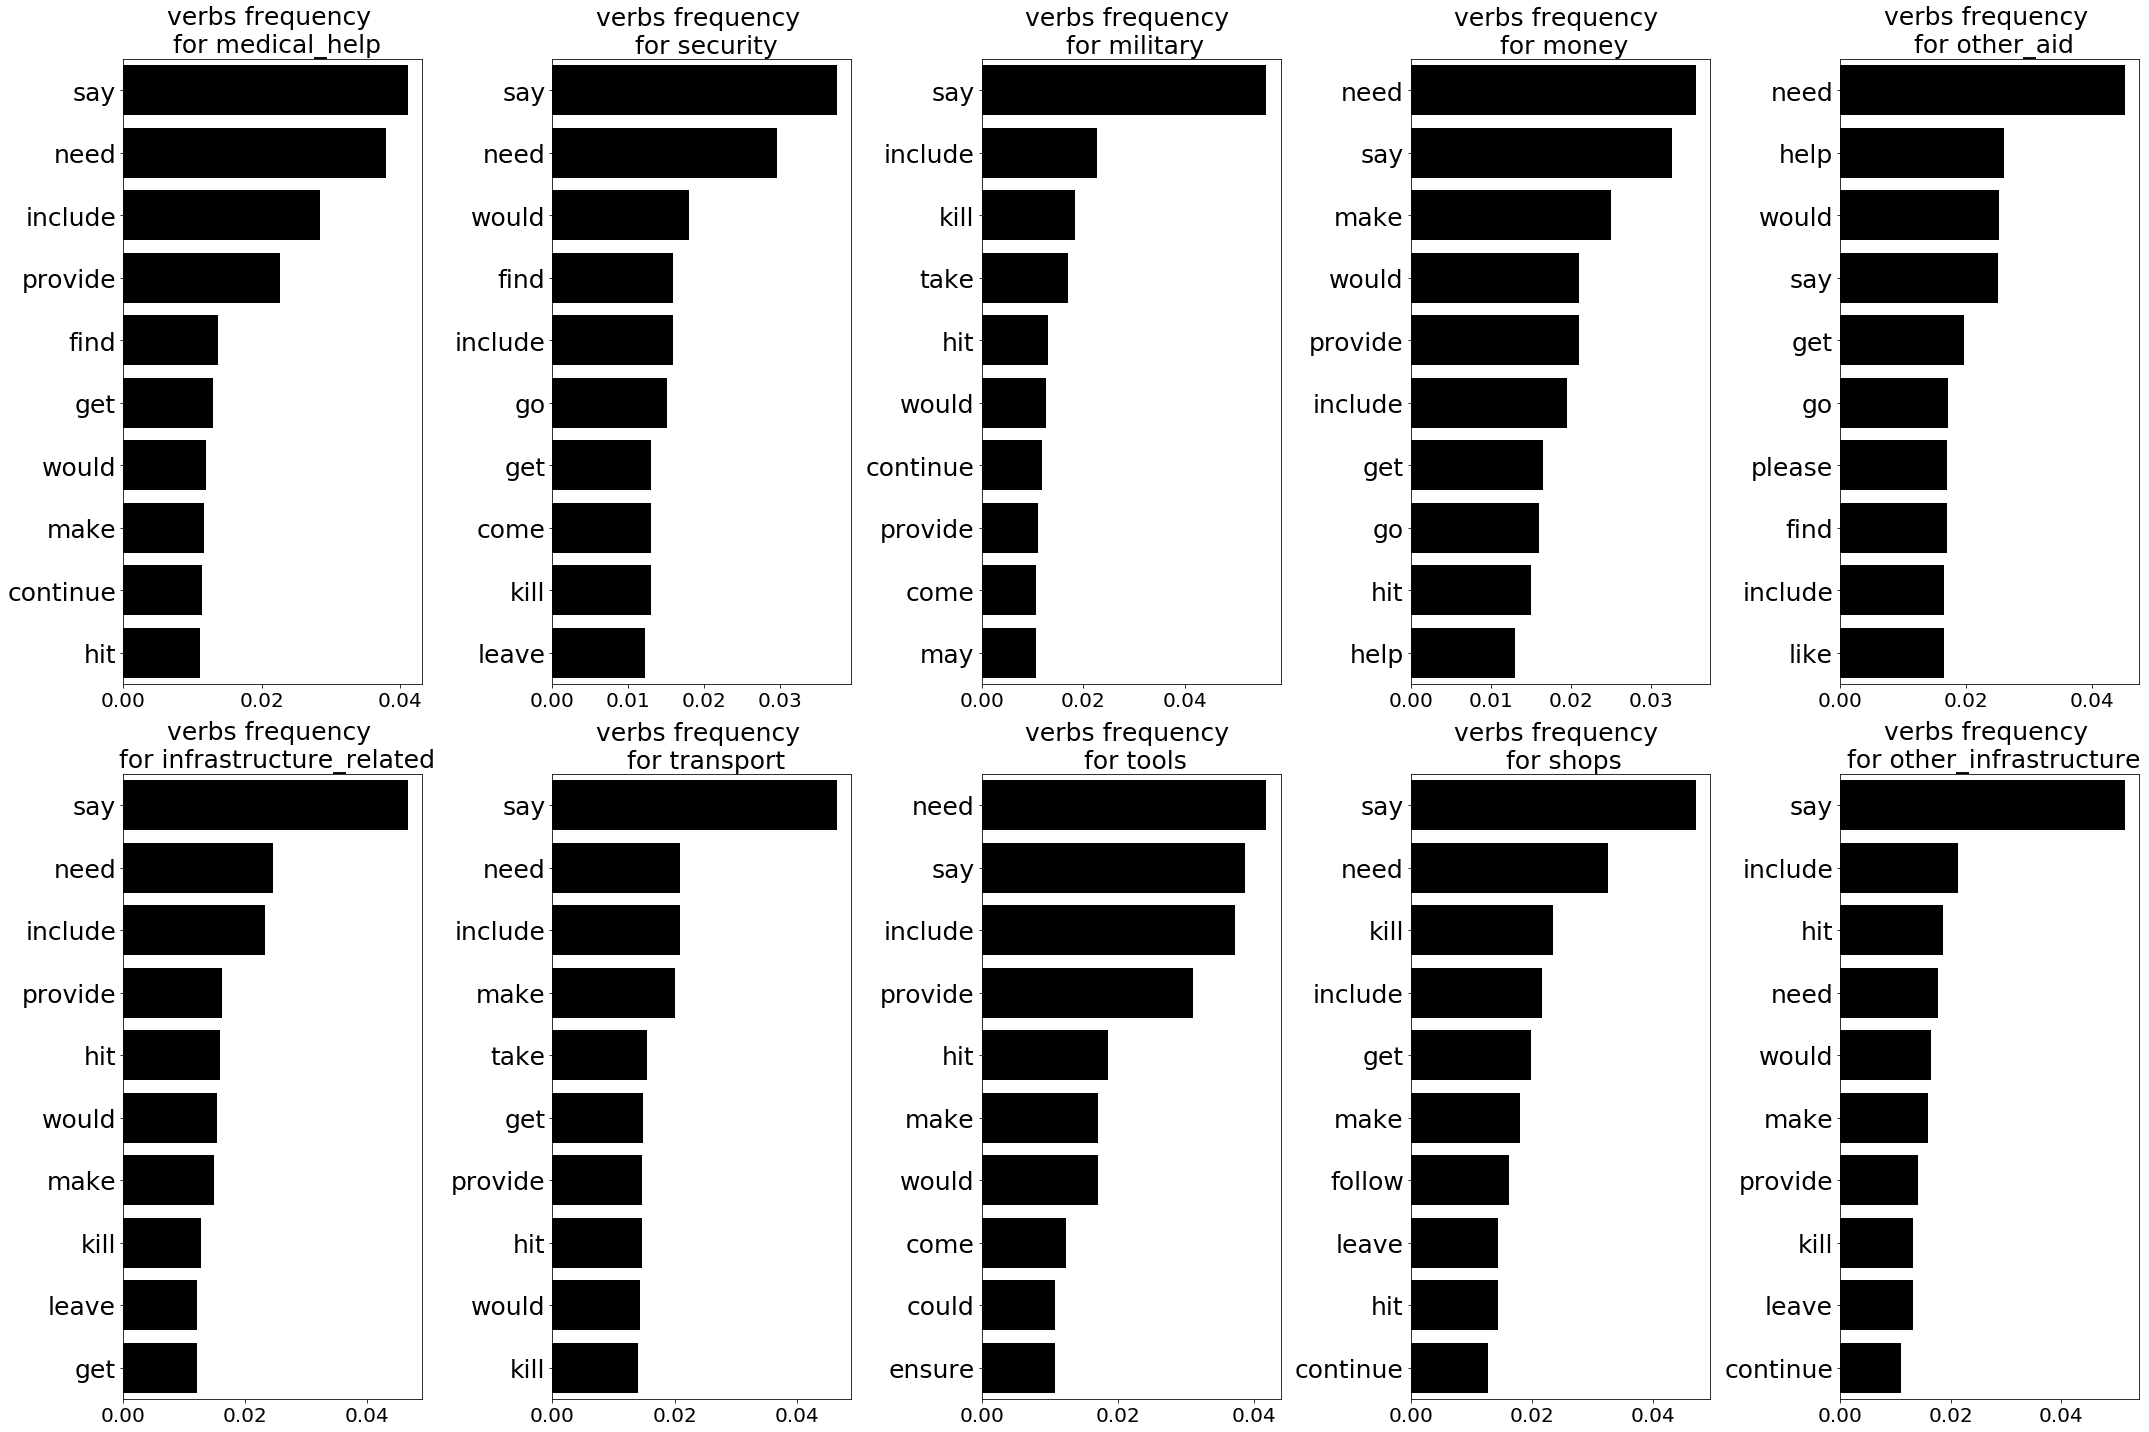

In [134]:
plot_pos_tags(df, 'verb', tag_mapping=tag_mapping)

There doesn't seem to be particular verbs appearing more in certain categories. Worse, it could add bias to our model since the same verbs come back a lot in all those categories. Let's take a look at adverbs.

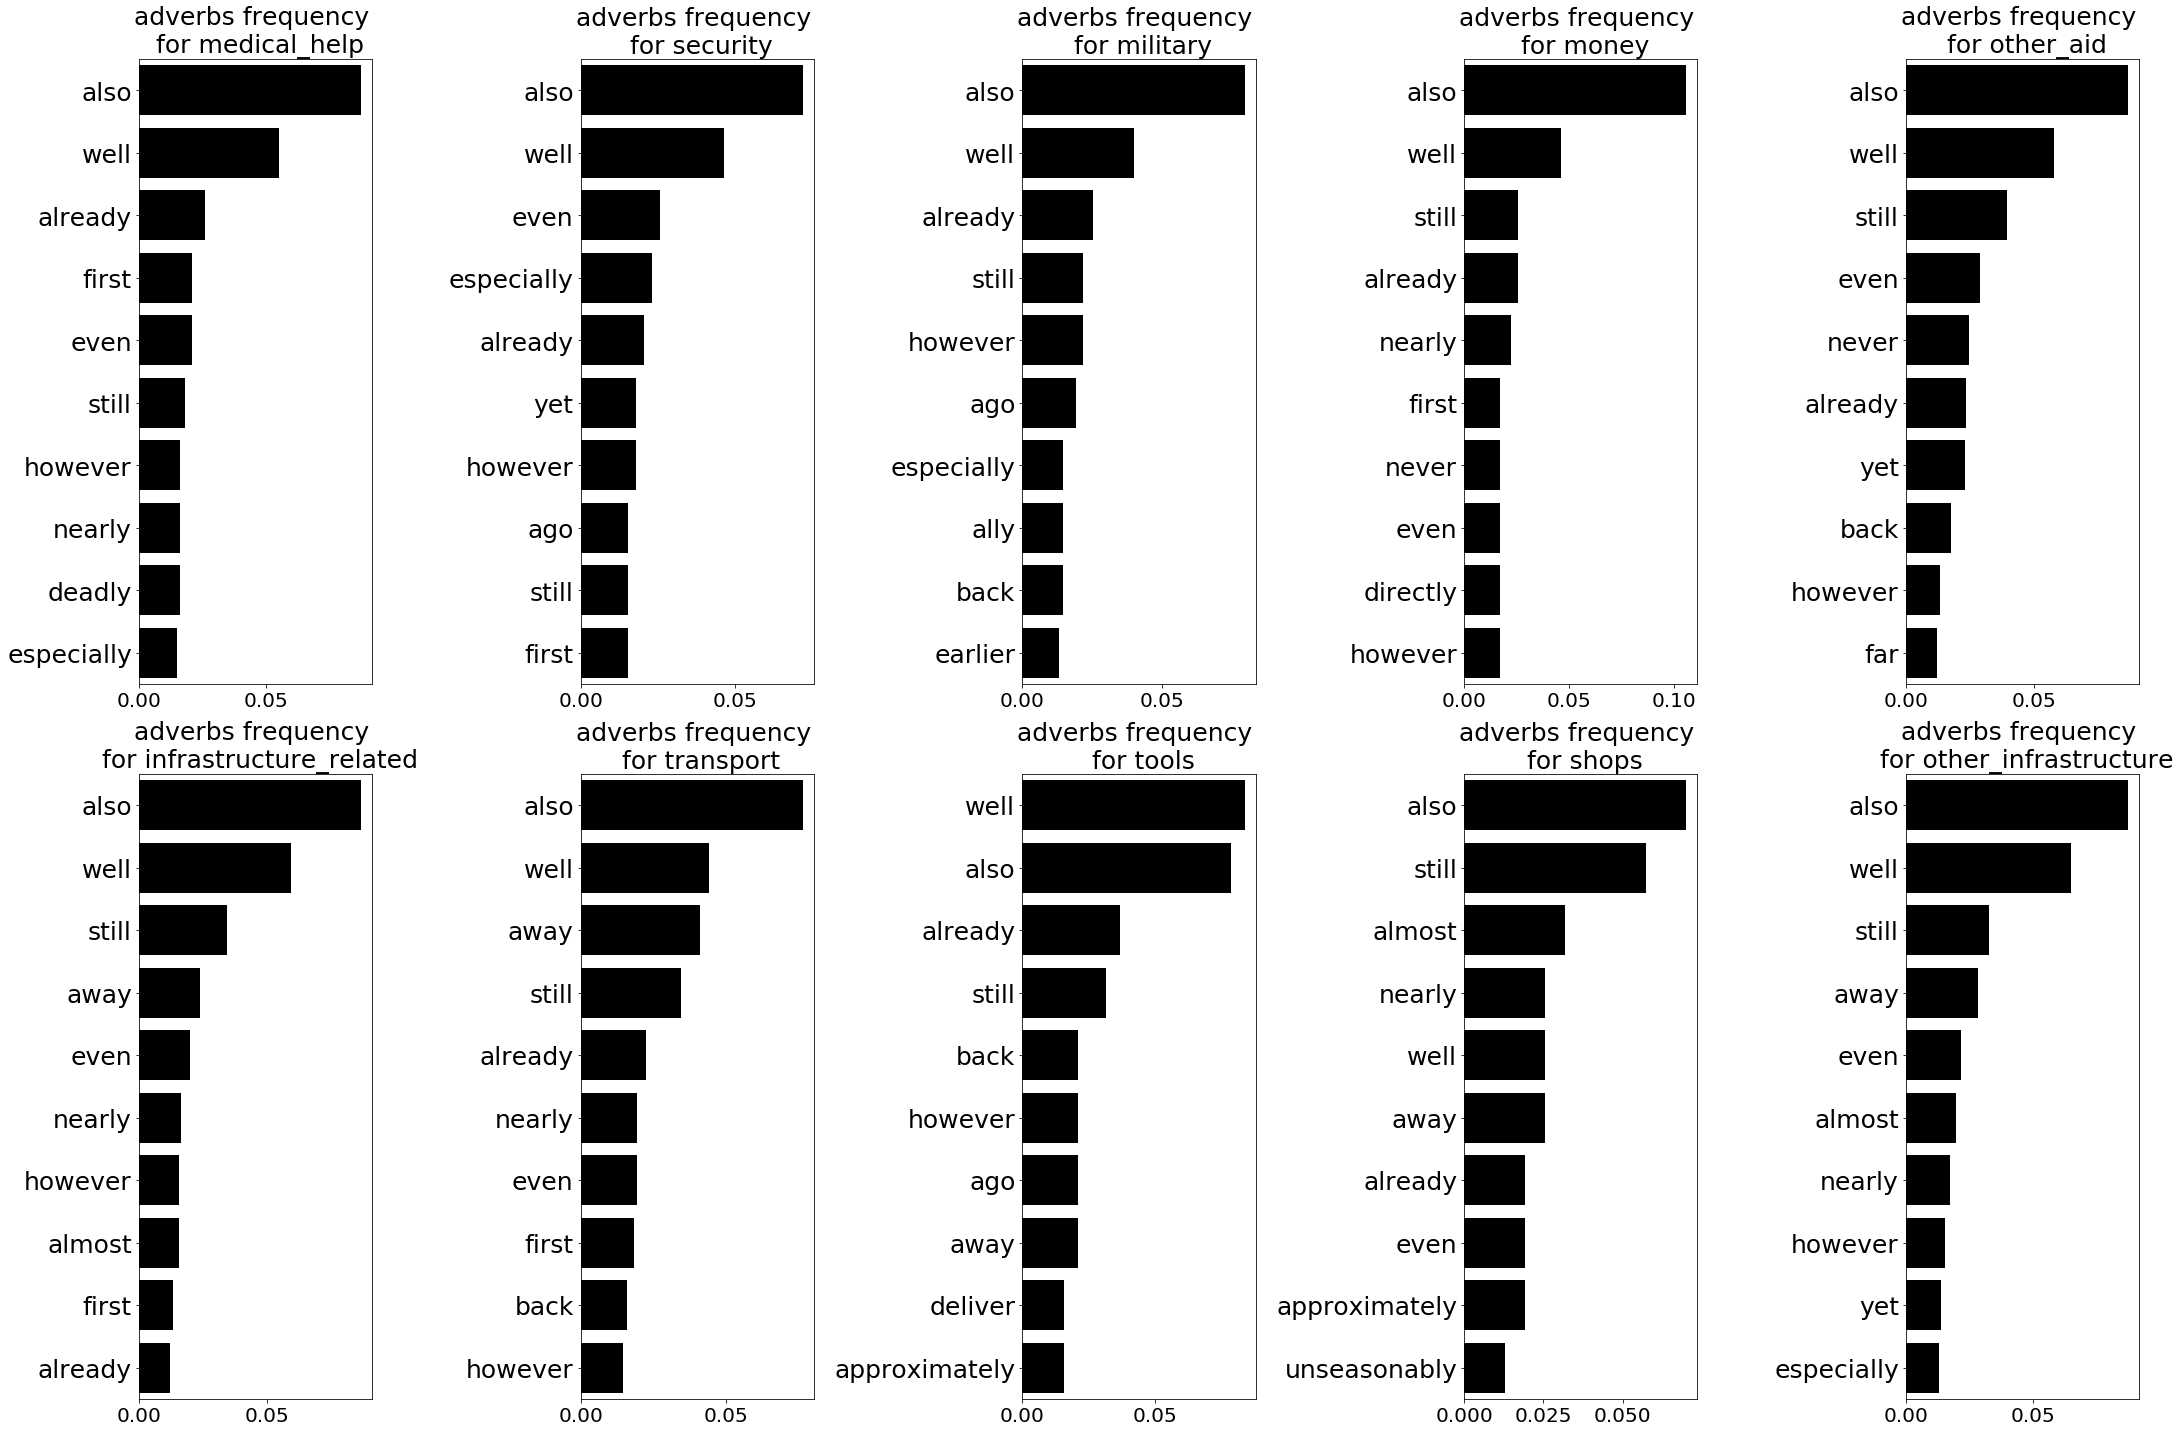

In [135]:
plot_pos_tags(df, 'adverb', tag_mapping=tag_mapping)

Same conclusion for adverbs. Finally, let's see what comes up for nouns

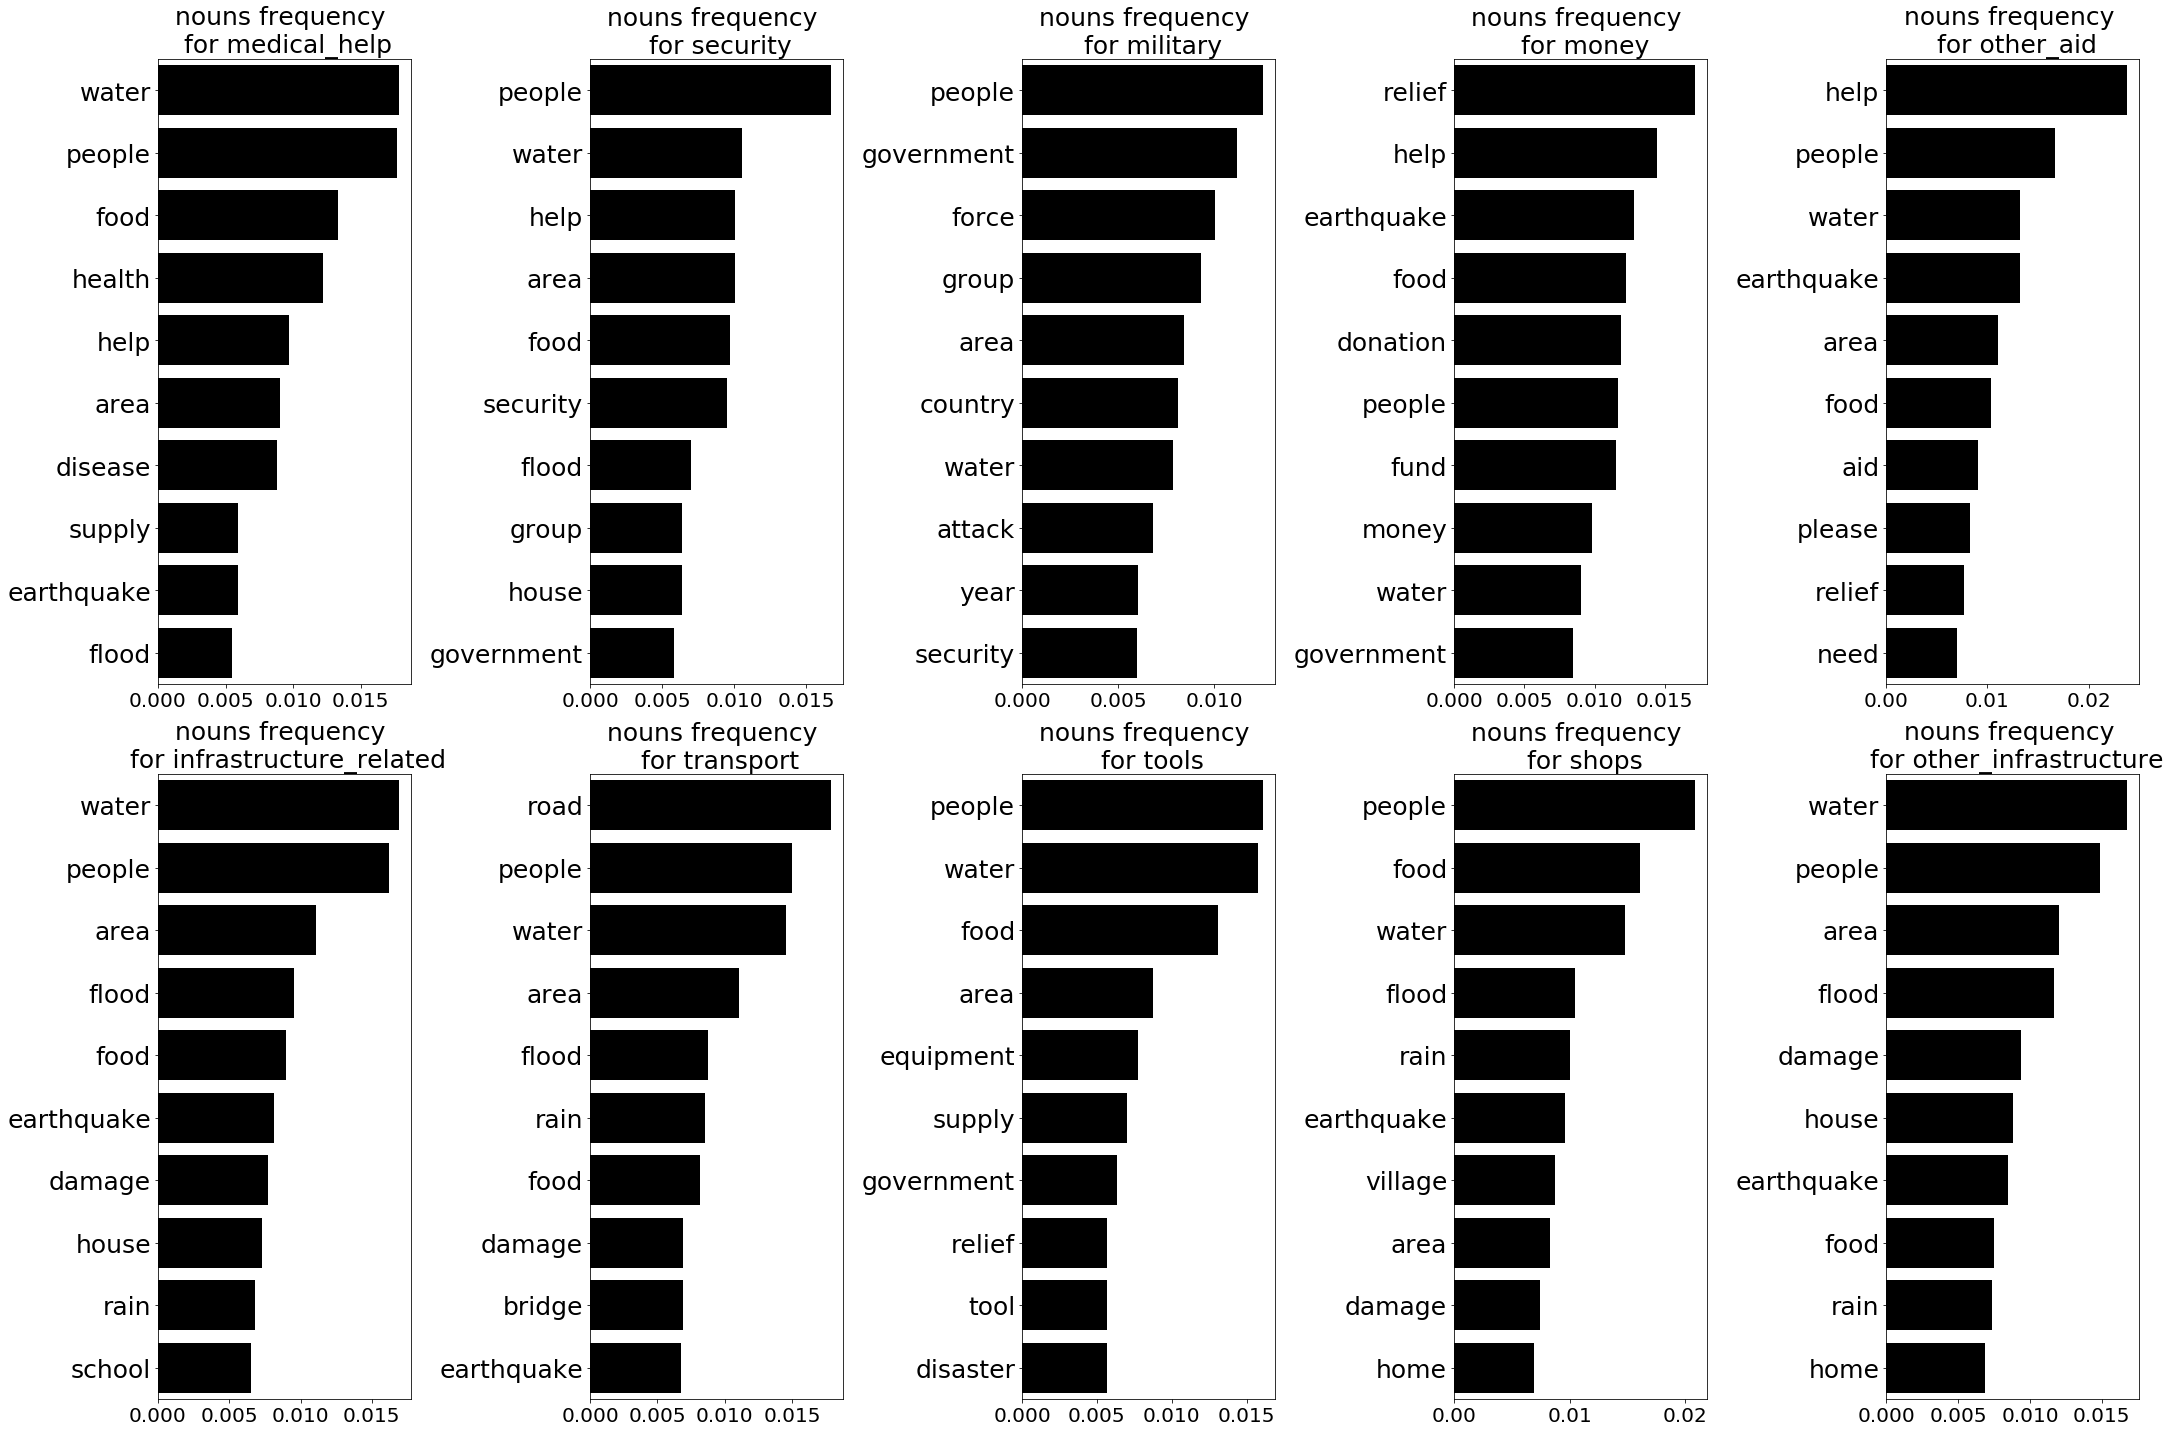

In [136]:
plot_pos_tags(df, 'noun', tag_mapping=tag_mapping)

Nouns seems to be helping with identifying the money category, but it still dominated by unrelated words. we might have to dig deeper

In [138]:
hardest_categories = ['other_aid', 'infrastructure_related', 'tools', 'shops', 'other_infrastructure', 'money']

In [2]:
# def mean_feature_per_class(feature):
#     d = {}
#     for col in category_colnames:
#         mask = df[col] == 1
#         d[col] = df.loc[mask, feature].mean()

#     feature_df = pd.DataFrame.from_dict(d, orient='index', columns=[feature])
#     return feature_df.sort_values(by=feature, ascending=False)

In [1]:
# fig, axes = plt.subplots(2, 3, figsize=(30, 20))
# axes_ravel = axes.ravel()

# features = ['char_count', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len']
# mean_feature_dfs = [mean_feature_per_class(feature) for feature in features]

# i = 0
# for mean_feature_df, feature in zip(mean_feature_dfs, features):
#     sb.barplot(data=mean_feature_df, x=feature, y=mean_feature_df.index, color=base_color, ax=axes_ravel[i]);
#     i = i + 1

### Topic Modeling
Let's apply topic modeling to our last categories and see what comes up. We will use Latent Dirichlet Allocation.

In [160]:
def topic_modelling(data):
    tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
    tf = tf_vectorizer.fit_transform(data['message'].values.astype('U'))
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
    return lda_model, tf, tf_vectorizer, tf_feature_names

In [161]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [175]:
def lda_topics(data):
    lda_model, tf, tf_vectorizer, tf_feature_names = topic_modelling(data)

    no_top_words = 6
    display_topics(lda_model, tf_feature_names, no_top_words)

In [176]:
for col in hardest_categories:
    filtered_df = df[df[col] == 1]
    lda_topics(filtered_df)

Topic 0:
sandy power school destroy house child
Topic 1:
flood also province hurricane people cause
Topic 2:
need emergency food help people assistance
Topic 3:
water supply food district red health
Topic 4:
area say work country damage victim
Topic 5:
help please need earthquake would like
Topic 6:
earthquake include year affect report family
Topic 7:
aid support village people take day
Topic 8:
rain government continue local heavy give
Topic 9:
relief haiti disaster community international tsunami
Topic 0:
earthquake hit relief part tsunami since
Topic 1:
flood say rain report cause affect
Topic 2:
year people rain state force would
Topic 3:
area community people make local water
Topic 4:
health supply school include provide child
Topic 5:
destroy damage home house flood village
Topic 6:
food need help hospital emergency please
Topic 7:
water system say power road building
Topic 8:
people shelter city kill temporary find
Topic 9:
area sandy two well hurricane away
Topic 0:
food peopl

By looking at the topics, we can clearly see that the main subject revolves around money, donations, fundings, cash, etc..

### 8. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [186]:
engine = create_engine('sqlite:///DisasterResponse.db')
df.to_sql('DisasterResponse', engine, index=False)

### 9. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.